# MTH416_FinalProject

## Q1 Implement Convolutional Neural Network  for the classification of the clinical disease

First of all, let's import the required packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import numpy as np

We need to view the images in the data set, so we use the PIL package to read the pictures for drawing and view the basic situation of the data set.

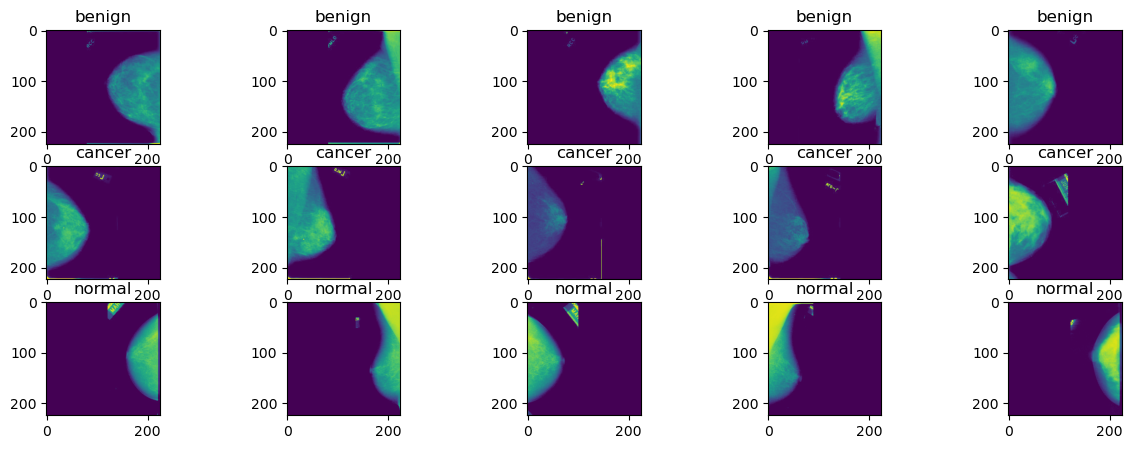

In [2]:
import matplotlib.pyplot as plt
import os
from PIL import Image
labels=['benign', 'cancer', 'normal']
plt.figure(figsize=(15, 5))
for i, class_name in enumerate(labels):
    class_path = os.path.join('train/', class_name)
    image_files = os.listdir(class_path)[:5]  #Take the first 5 image
        
    for j, img_file in enumerate(image_files):
        img_path = os.path.join(class_path, img_file)
        img = Image.open(img_path)
        ax = plt.subplot(3, 5, i*5 + j + 1)
        plt.imshow(img)
        plt.title(class_name)
plt.show()


We can find that this is a classification task of a medical image dataset. We need to label the image data with corresponding tags and read it in to train the model. First, we obtain the jpg file paths in the three folders "train", "test", and "val", and label them according to the subfolders (benign, cancer, normal) where they are located. Finally, a list containing the file paths and labels is generated to facilitate subsequent operations.

Note that in the downloaded test file, there is a file named 'malignant', which has a similar meaning to 'cancer' in other files. Therefore, I uniformly change it to cancer.

In [3]:
import os

def get_labeled_data_paths(base_dir):
    data = []
    #Divide the dataset and the labels
    datasets = ['train', 'test', 'val']
    label = {
        'normal': 0,
        'benign': 1,
        'cancer': 2
    }
    for i in datasets:
        path = os.path.join(base_dir, i)
        #get all subdirectories under this path
        for label_name, label_id in label.items():
            label_dir = os.path.join(path, label_name)
            #read all the jpg files under this lable
            for file_name in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file_name)
                data.append([file_path, label_id])
    return data

labeled_data = get_labeled_data_paths('.')
labeled_data

[['.\\train\\normal\\A_0003_1.LEFT_CC.jpg', 0],
 ['.\\train\\normal\\A_0003_1.LEFT_MLO.jpg', 0],
 ['.\\train\\normal\\A_0003_1.RIGHT_CC.jpg', 0],
 ['.\\train\\normal\\A_0003_1.RIGHT_MLO.jpg', 0],
 ['.\\train\\normal\\A_0005_1.LEFT_CC.jpg', 0],
 ['.\\train\\normal\\A_0005_1.LEFT_MLO.jpg', 0],
 ['.\\train\\normal\\A_0005_1.RIGHT_CC.jpg', 0],
 ['.\\train\\normal\\A_0005_1.RIGHT_MLO.jpg', 0],
 ['.\\train\\normal\\A_0006_1.LEFT_CC.jpg', 0],
 ['.\\train\\normal\\A_0006_1.LEFT_MLO.jpg', 0],
 ['.\\train\\normal\\A_0006_1.RIGHT_CC.jpg', 0],
 ['.\\train\\normal\\A_0006_1.RIGHT_MLO.jpg', 0],
 ['.\\train\\normal\\A_0009_1.LEFT_CC.jpg', 0],
 ['.\\train\\normal\\A_0009_1.LEFT_MLO.jpg', 0],
 ['.\\train\\normal\\A_0009_1.RIGHT_CC.jpg', 0],
 ['.\\train\\normal\\A_0009_1.RIGHT_MLO.jpg', 0],
 ['.\\train\\normal\\A_0010_1.LEFT_CC.jpg', 0],
 ['.\\train\\normal\\A_0010_1.LEFT_MLO.jpg', 0],
 ['.\\train\\normal\\A_0010_1.RIGHT_CC.jpg', 0],
 ['.\\train\\normal\\A_0010_1.RIGHT_MLO.jpg', 0],
 ['.\\train\\normal\

After that, we can read the images based on the previously obtained file paths and convert them into PyTorch Tensors, while retaining the labels to construct a dataset suitable for neural network training. I created the CancerImageDataset class to implement this function. Among them, data_list is the list containing image paths and labels mentioned above, in the format of [['path1', label1], ['path2', label2],...] . Then we used PyTorch's Transforms.pose to combine multiple preprocessing operations into a pipeline, as shown below:

1. Adjust all input images to 256×256 pixels. By consulting the materials, it was found that the size of 256*256 is mostly used in medical image classification, which is helpful for the model to detect lesions

2. Convert the PIL image to a PyTorch Tensor

3. Normalize using the mean and standard deviation of the general ImageNet, where mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]


In [4]:
import os
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader

#Create the CancerImageDataset class

class CancerImageDataset(Dataset):
    def __init__(self, data_list): #Data Preprocessing
        self.data = data_list
        self.transform = transforms.Compose([
        # Resize The size of the first model is (224, 224).
        # #The subsequent model is of a size of (256, 256), 
        # and here is the data after parameter adjustment.
            transforms.Resize((256, 256)),  
            transforms.ToTensor(),          #turn into Tensor
            transforms.Normalize(          #Normalization
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        # Read the image
        img = Image.open(img_path).convert('RGB')
        # Pre-processing
        img_tensor = self.transform(img)
        # Convert the label to tensor
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        return img_tensor, label_tensor

# Get all data paths
data_path_list = get_labeled_data_paths('.')
    
#Divide the training set, validation set and test set
train_data = [item for item in data_path_list if "train" in item[0]]
val_data = [item for item in data_path_list if "val" in item[0]]
test_data = [item for item in data_path_list if "test" in item[0]]
train_dataset = CancerImageDataset(train_data)
val_dataset = CancerImageDataset(val_data)
test_dataset = CancerImageDataset(test_data)
    
# Create the DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#The DataLoader of the validation set 
#and the test set does not need to be shuffled
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

#Test a batch
sample_images, sample_labels = next(iter(train_loader))
print(f"img_tensor_shape: {sample_images.shape}")  # should be [batch_size, 3, 224, 224]
print(f"label_tensor_shape: {sample_labels.shape}")  #should be [batch_size]


img_tensor_shape: torch.Size([32, 3, 256, 256])
label_tensor_shape: torch.Size([32])


Here, the nn.Sequential() function is used to construct the network structure. This way of writing is more hierarchical, more intuitive, more modular, and the output of features or classifier can be tested separately. Because our training data is medical data, a relatively complex network structure may be required. Therefore, this report employs four convolutional layers and three fully connected layers, and uses two dropout rates to randomly drop some nodes to prevent overfitting. The structure is as follows:

conv1()->ReLU()->MaxPooling2d()

conv2()->ReLU()->MaxPooling2d()

conv3()->ReLU()->MaxPooling2d()

conv4()->ReLU()->MaxPooling2d()

Flatten()

linear1()->ReLU()->Dropout()

linear2()->ReLU()->Dropout()

linear3()

Among them, the feature extraction part has four convolutional layers from conv1 to conv4. The first layer uses 32 convolutional kernels with an input of 224\*224 (the parameter is later adjusted to 256*256), and then gradually increases to 256 convolutional kernels with an input of 14\*14. After each convolutional layer, the ReLU activation function is used, and the MaxPooling2d function is employed for pooling. The pooling kernel size is 2x2, and the step size is 2. In the Classifier part, linear1-linear3 are three fully connected layers. The ReLU activation function is used, and the Dropout function is used to randomly drop 50% of the nodes to prevent overfitting. Dropout should be placed after the activation function. The purpose of Dropout is to randomly discard the activation values of neurons (i.e., the output after ReLU), rather than the original input. If placed before Linear, it may affect the way the weights are updated, leading to unstable training. Meanwhile, in classification tasks, Dropout is generally not added to the last layer (output layer) because we need a complete probability distribution for prediction.


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import time
from tqdm import tqdm

# Define Neural networks
class CancerImageCNN(nn.Module):
    def __init__(
        self, 
        num_classes=3,
        filter1_size=32,
        filter2_size=64,
        filter3_size=128,
        filter4_size=256,
        fc_1size=256*16*16,  #input is 256x256
        fc_2size=1024,
        fc_3size=512,
        dropout_rate=0.5,
        ):
        super().__init__()
        self.features = nn.Sequential(
            # 输入: 3x256x256
            nn.Conv2d(in_channels=3, 
                      out_channels=filter1_size, 
                      kernel_size=3, 
                      padding=1),  # 32x256x256
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # 32x128x128
            
            nn.Conv2d(in_channels=filter1_size, 
                      out_channels=filter2_size, 
                      kernel_size=3, 
                      padding=1), # 64x128x128
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # 64x64x64
            
            nn.Conv2d(in_channels=filter2_size, 
                      out_channels=filter3_size, 
                      kernel_size=3, 
                      padding=1), # 128x64x64
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # 128x32x32
            
            nn.Conv2d(in_channels=filter3_size, 
                      out_channels=filter4_size, 
                      kernel_size=3, 
                      padding=1), # 256x32x32
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)        # 256x16x16
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(fc_1size, fc_2size),
            nn.ReLU(inplace=True),
            #Randomly discarding 50% of the neurons can reduce overfitting
            nn.Dropout(p=dropout_rate),
            nn.Linear(fc_2size, fc_3size),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate), 
            nn.Linear(fc_3size, num_classes))
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  #flatten
        # It can also be written like this: 
        # x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')
mynet = CancerImageCNN().to(device)
mynet(torch.randn(32, 3, 256, 256, device=device)).shape 
# The result should be torch.Size([32, 3])

torch.Size([32, 3])

After building the network, we can start to construct the training and test functions. First of all, we need to define a training function, which will train the network and return the training loss and validation loss recorded in history, and provide the accuracy of the training set and the accuracy of the validation set. Among them, when writing the evaluate function, we used the model.eval() method. the purpose is to put the network in eval mode. this is important when the network has layers that behaves differently in training and evaluation time, mainly dropout and batch norm.

In [6]:
#Training Function and Evaluation Function
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    batches = tqdm(train_loader, desc=f'Train Epoch {epoch}')
    for images, labels in batches:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        #Select the category with the largest value as the prediction
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        batches.set_postfix({
            'loss': running_loss/(total/images.size(0)),
            'acc': 100.*correct/total
        })
    
    train_loss = running_loss/len(train_loader)
    train_acc = 100.*correct/total
    return train_loss, train_acc

def evaluate(model, device, dataloader, criterion):
    model.eval() # puts the network in eval mode. this is important when the
    # network has layers that behaves differently in training and
    # evaluation time, e.g., dropout and batch norm.
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss/len(dataloader)
    val_acc = 100.*correct/total
    return val_loss, val_acc


Then we need to define a prediction function to obtain the predicted labels. We need to obtain predictions, true_labels, and probabilities (using the softmax function to calculate the probabilities), and write these three data into the dictionary. It is convenient for the subsequent drawing of the confusion matrix and the Precision-Recall curve.

In [7]:
################################################
def get_predictions(model, device, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return {
        'predictions': np.array(all_preds),
        'true_labels': np.array(all_labels),
        'probabilities': np.array(all_probs),
    }
#### The above is for the convenience of subsequent plotting, 
#### predictions are used for the confusion matrix, 
#### and probabilities are used for the roc curve

Next, let's construct the plotting function to draw the accuracy curve and the loss curve. We can read the train_loss, val_loss, train_acc and val_acc that save the history in the convolutional neural network for plotting.

In [8]:
#plot part
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))
    
    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

## Q3
The reason for conducting Q3 first here is to debug one model to the best condition first, and then compare the two models under the same parameters and processing environment. Therefore, Q2 will be completed later

Since our data belongs to imbalanced data, the proportion of images in the cancer category is very small, resulting in misjudgment due to general accuracy. Therefore, we need to draw the confusion matrix and the Recalling-precision curve to evaluate the performance of the model more accurately.

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. 
Precision ($P$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false positives ($F_p$).

$$P=\frac{T_p}{T_p+F_p} $$

 
Recall ($R$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false negatives ($F_n$).
$$R=\frac{T_p}{T_p+F_n} $$

The precision-recall curve shows the tradeoff between precision and recall for different thresholds. A high area under the curve represents both high recall and high precision. High precision is achieved by having few false positives in the returned results, and high recall is achieved by having few false negatives in the relevant results. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all relevant results (high recall).

Because we pay more attention to the accuracy of cancer classification, as misjudging cancer as normal has a very serious impact and causes great damage to the treatment of patients, it is very important whether the accuracy of cancer classification can be improved. To prevent misjudgments caused solely based on precision judgments, we will plot the precision-recall curve of cancer and normal.
This report uses the two packages, PrecisionRecallDisplay and average_precision_score, in the sklearn.metrics package to plot the precision-recall curve. However, since this model is a multi-classification problem, when drawing PrecisionRecall, it is necessary to convert the multi-classification problem into a binary classification problem. Some processing is needed. Set the current category to positive category 1 and other categories to negative category 0. The construction of the function is as follows:

**参考网址**:https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

In [9]:
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score
import matplotlib.pyplot as plt

def plot_multiclass_pr_curves(y_true, y_scores, class_names, focus_class=None):
    plt.figure(figsize=(12, 10))
    ax = plt.gca()  #Obtain the current axes item
    
    # Draw all category curves
    ap_scores = {}
    for i, name in enumerate(class_names):
        # Convert a multi-classification problem into a binary classification 
        # problem: The current category is positive class 1, 
        # and other categories are negative class 0
        y_true_binary = (y_true == i).astype(int)
            
        ap = average_precision_score(y_true_binary, y_scores[:, i])
        ap_scores[name] = ap
        
        # Set the color:
        # If it is focus_class, use red; otherwise, use the default color
        color = 'red' if (focus_class and name == focus_class) else None
        
        PrecisionRecallDisplay.from_predictions(
            y_true_binary,
            y_scores[:, i],
            name=f'{name} (AP={ap:.2f})',
            ax=ax, 
            color=color,
            plot_chance_level=(i==2),  #Draw the chance level curve of the cancer class
            linewidth=2
        )
    
    plt.title('Multiclass Precision-Recall Curves')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

After defining the above functions, we start to define the complete main training process. First of all, we need to initialize the model. Otherwise, after each parameter adjustment, we will continue to train on the previous basis.
Our loss function selects CrossEntropyLoss, the optimizer selects Adam, and the learning rate is set to 0.001. The Adam optimizer can not only accelerate optimization but also automatically adjust the learning rate, and it has a good optimization effect on deep learning models.


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd


# Main Training Process
def main():
    # set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    #Initialize the model
    model = CancerImageCNN(num_classes=3).to(device)
    
    #Define the loss function and the optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    #List of training records
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    #Training parameters

    epochs_num = 15
    best_acc = 0.0

    # Training epoches
    for epoch in range(1, epochs_num+1):
        start_time = time.time()
        
        train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
        val_loss, val_acc = evaluate(model, device, val_loader, criterion)
        
        # Record historical training 
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save the best model locally
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch}/{epochs_num} | Time: {epoch_time:.2f}s')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print('-' * 60)
    
    # testset test
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc = evaluate(model, device, test_loader, criterion)
    print(f'\nFinal Test Performance:')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')
    
    # Draw the curve of training and validation accuracy and loss
    plot_training_curves(history)
    
    #Draw the confusion matrix and recall rate 
    #related to the prediction results
    test_results = get_predictions(model, device, test_loader)
    y_true = test_results['true_labels']  # true label group
    y_pred = test_results['predictions']  # prediction label group
    classes = ['normal','benign','cancer']  # name of classes
    cm = confusion_matrix(y_true, y_pred)  # confusion matrix
    df_cm = pd.DataFrame(cm) 
    
    print("confusion matrix: \n", df_cm,"col:true label, row:predicted label")
    
    #Draw the PR curve for each category
    #Pay special attention to the cancer category
    y_scores = test_results['probabilities']
    plot_multiclass_pr_curves(y_true, y_scores, classes, focus_class='cancer')

Using device: cuda


Train Epoch 1: 100%|██████████| 77/77 [00:15<00:00,  4.85it/s, loss=0.472, acc=86]  


Epoch 1/15 | Time: 17.76s
Train Loss: 0.4871 | Train Acc: 86.03%
Val Loss: 0.4779 | Val Acc: 88.12%
------------------------------------------------------------


Train Epoch 2: 100%|██████████| 77/77 [00:15<00:00,  5.01it/s, loss=0.419, acc=87.1]


Epoch 2/15 | Time: 17.13s
Train Loss: 0.4325 | Train Acc: 87.13%
Val Loss: 0.4603 | Val Acc: 89.11%
------------------------------------------------------------


Train Epoch 3: 100%|██████████| 77/77 [00:15<00:00,  5.00it/s, loss=0.387, acc=87.8]


Epoch 3/15 | Time: 16.60s
Train Loss: 0.3990 | Train Acc: 87.82%
Val Loss: 0.4278 | Val Acc: 89.11%
------------------------------------------------------------


Train Epoch 4: 100%|██████████| 77/77 [00:15<00:00,  4.97it/s, loss=0.382, acc=87.7]


Epoch 4/15 | Time: 17.29s
Train Loss: 0.3946 | Train Acc: 87.66%
Val Loss: 0.3981 | Val Acc: 89.44%
------------------------------------------------------------


Train Epoch 5: 100%|██████████| 77/77 [00:15<00:00,  4.98it/s, loss=0.366, acc=88.1]


Epoch 5/15 | Time: 16.69s
Train Loss: 0.3779 | Train Acc: 88.06%
Val Loss: 0.3940 | Val Acc: 88.78%
------------------------------------------------------------


Train Epoch 6: 100%|██████████| 77/77 [00:15<00:00,  4.96it/s, loss=0.343, acc=88.3]


Epoch 6/15 | Time: 16.70s
Train Loss: 0.3544 | Train Acc: 88.27%
Val Loss: 0.4541 | Val Acc: 89.11%
------------------------------------------------------------


Train Epoch 7: 100%|██████████| 77/77 [00:15<00:00,  4.99it/s, loss=0.31, acc=89.6] 


Epoch 7/15 | Time: 16.62s
Train Loss: 0.3201 | Train Acc: 89.57%
Val Loss: 0.4180 | Val Acc: 87.79%
------------------------------------------------------------


Train Epoch 8: 100%|██████████| 77/77 [00:15<00:00,  4.97it/s, loss=0.277, acc=90.4]


Epoch 8/15 | Time: 17.30s
Train Loss: 0.2858 | Train Acc: 90.38%
Val Loss: 0.3992 | Val Acc: 90.10%
------------------------------------------------------------


Train Epoch 9: 100%|██████████| 77/77 [00:15<00:00,  5.01it/s, loss=0.26, acc=90.5] 


Epoch 9/15 | Time: 17.15s
Train Loss: 0.2681 | Train Acc: 90.50%
Val Loss: 0.4206 | Val Acc: 91.09%
------------------------------------------------------------


Train Epoch 10: 100%|██████████| 77/77 [00:15<00:00,  4.99it/s, loss=0.236, acc=92]  


Epoch 10/15 | Time: 16.63s
Train Loss: 0.2434 | Train Acc: 92.00%
Val Loss: 0.5340 | Val Acc: 88.78%
------------------------------------------------------------


Train Epoch 11: 100%|██████████| 77/77 [00:15<00:00,  4.99it/s, loss=0.218, acc=92.8]


Epoch 11/15 | Time: 16.61s
Train Loss: 0.2253 | Train Acc: 92.77%
Val Loss: 0.4358 | Val Acc: 90.10%
------------------------------------------------------------


Train Epoch 12: 100%|██████████| 77/77 [00:15<00:00,  4.99it/s, loss=0.195, acc=93.7]


Epoch 12/15 | Time: 16.63s
Train Loss: 0.2013 | Train Acc: 93.67%
Val Loss: 0.4737 | Val Acc: 88.78%
------------------------------------------------------------


Train Epoch 13: 100%|██████████| 77/77 [00:15<00:00,  5.03it/s, loss=0.137, acc=95.2]


Epoch 13/15 | Time: 16.50s
Train Loss: 0.1412 | Train Acc: 95.25%
Val Loss: 0.5760 | Val Acc: 90.76%
------------------------------------------------------------


Train Epoch 14: 100%|██████████| 77/77 [00:15<00:00,  5.09it/s, loss=0.134, acc=95.3]


Epoch 14/15 | Time: 16.32s
Train Loss: 0.1383 | Train Acc: 95.29%
Val Loss: 0.5675 | Val Acc: 89.44%
------------------------------------------------------------


Train Epoch 15: 100%|██████████| 77/77 [00:15<00:00,  5.06it/s, loss=0.111, acc=96.1] 


Epoch 15/15 | Time: 16.41s
Train Loss: 0.1147 | Train Acc: 96.06%
Val Loss: 0.6547 | Val Acc: 90.43%
------------------------------------------------------------


C:\Users\zhuanghuo\AppData\Local\Temp;\ipykernel_7724\1524521369.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Final Test Performance:
Test Loss: 0.5725 | Test Acc: 88.52%


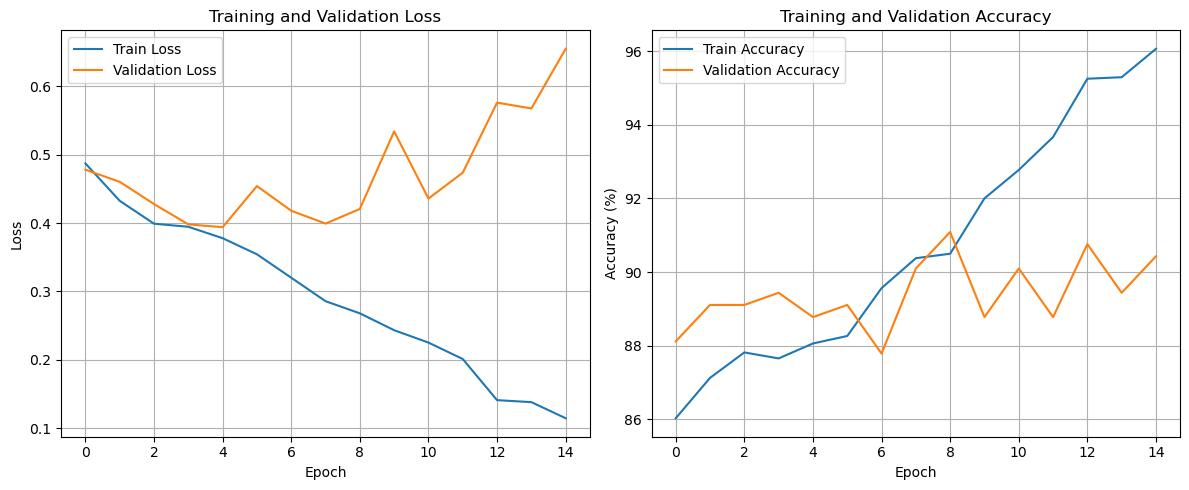

confusion matrix: 
      0  1  2
0  262  4  1
1   15  4  1
2   12  2  4 col:true label, row:predicted label


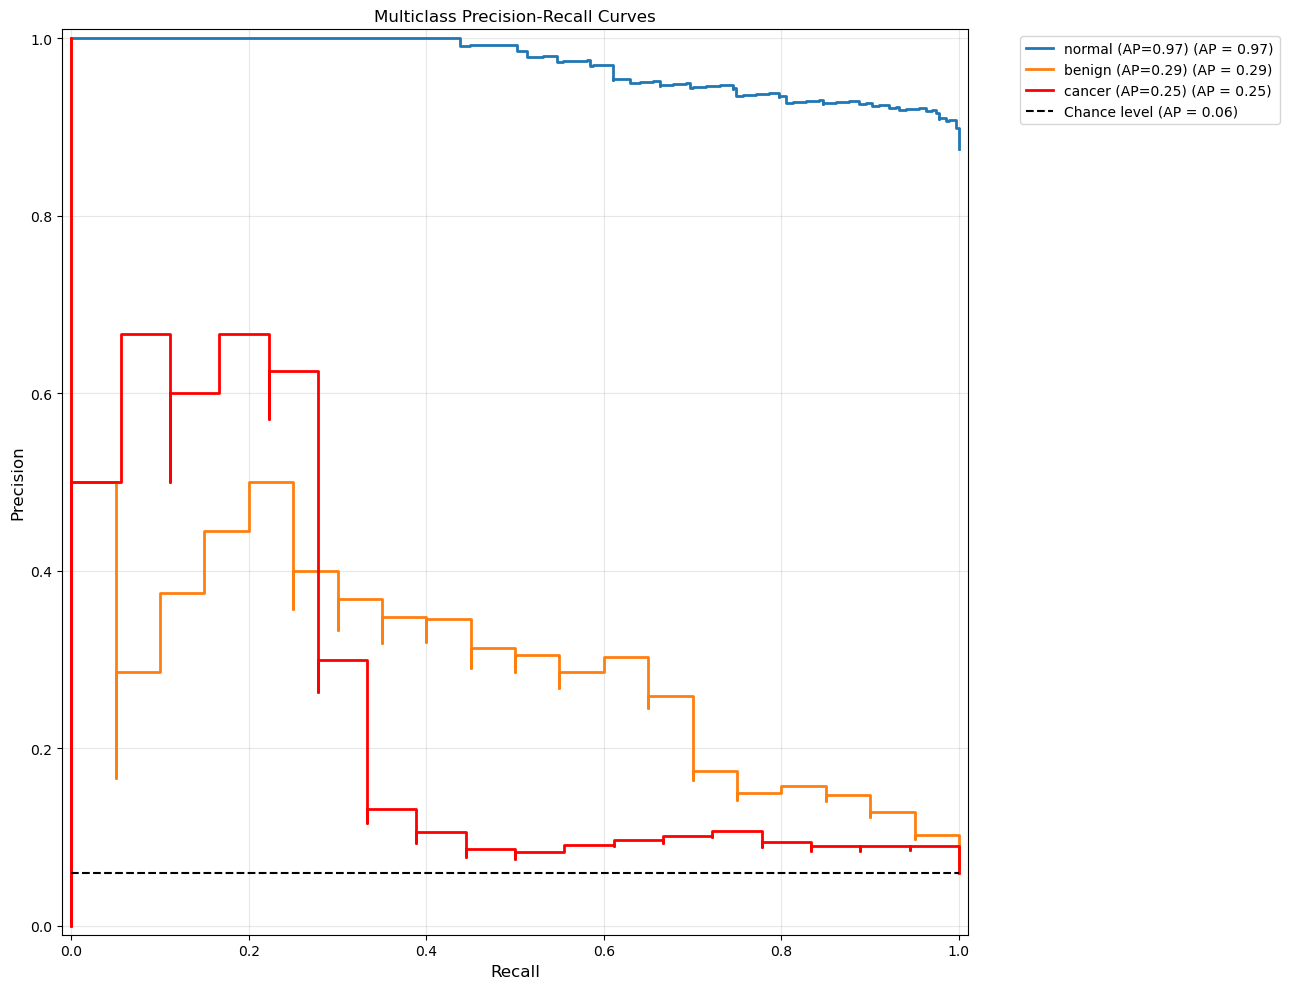

In [11]:
if __name__ == "__main__":
    main()


It can be seen from the above results that the train accuracy of the model has reached up to 96% at most. However, the accuracy of the validation set and the test set is very low, with the highest validation accuracy being 91%. The accuracy rate of the test set is only about 88%. It can be seen from the loss curves and accuracy curves of the validation set and the training set that the loss curve of the validation set also increases after the number of trainings increases, accompanied by fluctuations in accuracy. This indicates that the model is overfitted to the training set, resulting in poor performance on the test set and the validation set. 

And from the PrecisionRecall graph, it can be seen that the recall value of the cancer category is much lower than that of noramal. From the confusion matrix, we can see that one-third of the cancer and benign samples in the test set were misjudged as the normal category. The consequences of misjudging the cancer category as the normal category will be serious, so we mainly need to solve this problem. If the model training data is imbalanced data, it will lead to misjudgment of accuracy. Therefore, we need to expand the data set. This problem can be solved by means such as oversampling to balance the samples or weighting the model.

## Q4. Improving Class Imbalance

So we plan to make the following two improvements to solve the problem of class imbalance:

1. Add weights to the loss function

2. Increase the number of cancer samples through methods such as oversampling.

We choose to increase the sample size of cancer through oversampling and add weights to the loss function in the network. We can assign smaller weights to the normal samples and larger weights to the cancer samples. This can enable the model to pay more attention to the prediction accuracy of cancer samples. At the same time, the number of samples in the benign class can also be appropriately increased to balance the samples, because the number of benign samples is also relatively small. So we changed the network structure and the main training process as follows:

1. Adjust all input images to 256×256 pixels. By consulting the materials, it was found that the size of 256*256 is mostly used in medical image classification, which is helpful for the model to detect lesions

2. We modified the dataset and oversampled the cancer and benign samples, increasing the number of cancer samples to ten times the original and the number of benign samples to five times the original. Originally, there were 132 cancer samples and 186 benign samples. Now, they have been expanded to 1,320 and 930 respectively.

3. Add weights to the loss function so that the model pays more attention to the prediction accuracy of cancer samples.

4. The convolutional layers of the model have been reduced, as too many convolutional layers can lead to overfitting of the model.

5. A Learning Rate Scheduler was created, and StepLR was used to dynamically adjust the learning rate during training. Gradually reduce the learning rate according to the specified rules to help the model converge better. Parameter description: optimizer: The bound optimizer (such as SGD, Adam, etc.). step_size: Adjust the step size of the learning rate (unit: epoch); After each step_size epoch, the learning rate will be multiplied by gamma; gamma: The multiplicative factor of learning rate decay
After debugging, our step size is set to 5 and gamma is set to 0.1. That is, every 5 epochs, the learning rate is multiplied by 0.1.

6. A batch normalization layer has been added to prevent possible overfitting phenomena.


First, we attempt to Use upsampling to balance the samples in each class on the test set. As shown below, we have written a resampling function:

The resampling function is as follows:

Parameter:

    original_data: [(img_path, label), ...] The list

    target_class: The target category that needs to be oversampled

    multiplier: The multiple that increases the sample size of the target category

Return:

    The list of the resampled dataset








In [11]:
import random
import numpy as np
from torchvision import transforms
from collections import Counter

def create_oversampled_dataset(original_data, target_class, multiplier):
    # Separate the target class and non-target class samples
    target_samples = [item for item in original_data if item[1] == target_class]
    non_target_samples = [item for item in original_data if item[1] != target_class]
    
    #count the original_target
    original_target_count = len(target_samples)
    
    # Basic random oversampling (with replacement)
    new_target_samples = random.choices(
        target_samples, 
        k=original_target_count * (multiplier - 1)
        )
    # Merge the new and old samples
    oversampled_data = non_target_samples + target_samples + new_target_samples
    # Verify the sampling count
    print(f"Aftrer oversampleing: {Counter([d[1] for d in oversampled_data])}")
    return oversampled_data

##The sample size of the cancer category is very small and the 
#judgment accuracy is very important. 
# Therefore, oversampling of this category is conducted first to 
# expand the sample to 10 times the original size
train_data_oversampled=create_oversampled_dataset(train_data,2,multiplier=10)
####At the same time, the sample size of begin is also expanded to 10 folds
train_data_oversampled=create_oversampled_dataset(train_data_oversampled,1,multiplier=10)
# only change the training set
train_dataset_oversampled = CancerImageDataset(train_data_oversampled)
val_dataset = CancerImageDataset(val_data)
test_dataset = CancerImageDataset(test_data)
    
#Create DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset_oversampled, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

sample_images, sample_labels = next(iter(train_loader))
print(f"img_tensor_shape: {sample_images.shape}")  #should be [32, 3, 224, 224]
print(f"label_tensor_shape: {sample_labels.shape}")  #should be [32]


Aftrer oversampleing: Counter({0: 2145, 2: 1320, 1: 186})
Aftrer oversampleing: Counter({0: 2145, 1: 1860, 2: 1320})
img_tensor_shape: torch.Size([32, 3, 256, 256])
label_tensor_shape: torch.Size([32])


Then we modified the model, deleted one convolutional layer, and added the batch normalization layer. Deleting the convolutional layer is hoped to reduce the overfitting phenomenon by reducing the parameters, because complex networks have more parameters and the risk of overfitting will also increase. The reason for adding the batch normalization layer is to enhance the generalization ability of the model by reducing the offset of internal covariates.

The modified structure of the convolutional neural network is as follows:

conv2()->ReLU()->batch_normalization()->MaxPooling2d()

conv3()->ReLU()->batch_normalization()->MaxPooling2d()

conv3()->ReLU()->->batch_normalization()MaxPooling2d()

Flatten()

linear1()->ReLU()->->batch_normalization()->Dropout()

linear2()->ReLU()->->batch_normalization()->Dropout()

linear3()

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import time
from tqdm import tqdm

import torch
import torch.nn as nn

class CancerImageCNN(nn.Module):
    def __init__(
        self, 
        num_classes=3,
        filter1_size=32,
        filter2_size=64,
        filter3_size=128,  # The fourth convolution layer has been removed
        fc_1size=128*32*32,  # Adjust the input size because the last convolution layer has been removed
        fc_2size=1024,
        fc_3size=512,
        dropout_rate=0.5,
        ):
        super().__init__()
        self.features = nn.Sequential(
            # input: 3x256x256
            nn.Conv2d(in_channels=3, 
                      out_channels=filter1_size, 
                      kernel_size=3, 
                      padding=1),  # 32x256x256
            nn.BatchNorm2d(filter1_size),  # add BatchNorm
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # 32x128x128
            
            nn.Conv2d(in_channels=filter1_size, 
                      out_channels=filter2_size, 
                      kernel_size=3, 
                      padding=1), # 64x128x128
            nn.BatchNorm2d(filter2_size),  # add BatchNorm
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # 64x64x64
            
            nn.Conv2d(in_channels=filter2_size, 
                      out_channels=filter3_size, 
                      kernel_size=3, 
                      padding=1), # 128x64x64
            nn.BatchNorm2d(filter3_size),  # add BatchNorm
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)       # 128x32x32
            # The fourth convolution layer and pooling layer has been removed
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(fc_1size, fc_2size),
            # BatchNorm is also added after the fully connected layer
            nn.BatchNorm1d(fc_2size),  \
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(fc_2size, fc_3size),
            # BatchNorm is also added after the fully connected layer
            nn.BatchNorm1d(fc_3size), 
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate), 
            nn.Linear(fc_3size, num_classes)
            )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1) #flatten
        x = self.classifier(x)
        return x

device = torch.device('cpu')

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')
mynet = CancerImageCNN().to(device)
mynet(torch.randn(32, 3, 256, 256, device=device)).shape 
#should be torch.Size([32, 3])

torch.Size([32, 3])

The main change in the training process is the reduction of training rounds, from 15 to 10. It can be seen from the previous training process that the model has almost converged after about ten training sessions. Reducing the number of training rounds not only shortens the training time but also helps prevent overfitting.

In [13]:
from sklearn.utils.class_weight import compute_class_weight

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = CancerImageCNN(num_classes=3).to(device)
    
    # Define the loss function and the optimizer
    
    ################## The loss function is weighted here
    # Extract all labels from the training dataset
    def get_all_labels(dataset):
        return [label for _, label in dataset]

    # Get all labels from the training set
    train_labels = get_all_labels(train_dataset)  # Note: using the original training set without resampling
    # If using resampled dataset, the weights would be approximately equal
    ################## Calculate class weights
    # class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=np.array(train_labels))
    ################## Apply weights in the loss function, note: using the original training set
    # criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    ################## Use StepLR to dynamically adjust learning rate during training
    scheduler = StepLR(optimizer, step_size=3, gamma=0.5)
    

    # Training history records
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Training parameters
    
    ## Debug settings
    epochs_num = 10  # Reduced number of training epochs
    best_acc = 0.0

    # Training loop
    for epoch in range(1, epochs_num+1):
        start_time = time.time()
        
        train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
        val_loss, val_acc = evaluate(model, device, val_loader, criterion)
        scheduler.step()
        
        # Record historical data
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch}/{epochs_num} | Time: {epoch_time:.2f}s')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print('-' * 60)
    
    # Final testing
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc = evaluate(model, device, test_loader, criterion)
    print(f'\nFinal Test Performance:')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')
    
    # Plot training curves
    plot_training_curves(history)
    
    # Plot confusion matrix and recall-related metrics for predictions
    test_results = get_predictions(model, device, test_loader)
    y_true = test_results['true_labels']  # Array of true labels
    y_pred = test_results['predictions']  # Array of predicted labels
    classes = ['normal','benign','cancer']  # Class names
    cm = confusion_matrix(y_true, y_pred)  # Confusion matrix
    df_cm = pd.DataFrame(cm) 
    
    print("Original confusion matrix:\n", df_cm, "where columns are true labels and rows are predicted labels")
    
    # Plot PR curves for each class
    # Special focus on the 'cancer' class
    y_scores = test_results['probabilities']
    plot_multiclass_pr_curves(y_true, y_scores, classes, focus_class='cancer')

Using device: cuda


Train Epoch 1: 100%|██████████| 167/167 [00:39<00:00,  4.21it/s, loss=0.231, acc=75.7]


Epoch 1/10 | Time: 42.19s
Train Loss: 0.5669 | Train Acc: 75.74%
Val Loss: 0.8578 | Val Acc: 88.12%
------------------------------------------------------------


Train Epoch 2: 100%|██████████| 167/167 [00:38<00:00,  4.30it/s, loss=0.0697, acc=93.7]


Epoch 2/10 | Time: 40.09s
Train Loss: 0.1709 | Train Acc: 93.71%
Val Loss: 1.3495 | Val Acc: 53.80%
------------------------------------------------------------


Train Epoch 3: 100%|██████████| 167/167 [00:39<00:00,  4.28it/s, loss=0.0325, acc=97.1]


Epoch 3/10 | Time: 41.54s
Train Loss: 0.0797 | Train Acc: 97.11%
Val Loss: 0.6127 | Val Acc: 90.76%
------------------------------------------------------------


Train Epoch 4: 100%|██████████| 167/167 [00:39<00:00,  4.27it/s, loss=0.0205, acc=98.2]


Epoch 4/10 | Time: 41.58s
Train Loss: 0.0503 | Train Acc: 98.23%
Val Loss: 0.2801 | Val Acc: 94.06%
------------------------------------------------------------


Train Epoch 5: 100%|██████████| 167/167 [00:39<00:00,  4.24it/s, loss=0.0209, acc=98.3]


Epoch 5/10 | Time: 40.64s
Train Loss: 0.0512 | Train Acc: 98.29%
Val Loss: 0.3694 | Val Acc: 92.74%
------------------------------------------------------------


Train Epoch 6: 100%|██████████| 167/167 [00:39<00:00,  4.21it/s, loss=0.00649, acc=99.5]


Epoch 6/10 | Time: 40.87s
Train Loss: 0.0159 | Train Acc: 99.51%
Val Loss: 0.4032 | Val Acc: 92.74%
------------------------------------------------------------


Train Epoch 7: 100%|██████████| 167/167 [00:39<00:00,  4.26it/s, loss=0.00615, acc=99.5]


Epoch 7/10 | Time: 40.43s
Train Loss: 0.0151 | Train Acc: 99.51%
Val Loss: 0.3198 | Val Acc: 93.07%
------------------------------------------------------------


Train Epoch 8: 100%|██████████| 167/167 [00:39<00:00,  4.24it/s, loss=0.00202, acc=99.9]


Epoch 8/10 | Time: 41.89s
Train Loss: 0.0050 | Train Acc: 99.92%
Val Loss: 0.2950 | Val Acc: 94.39%
------------------------------------------------------------


Train Epoch 9: 100%|██████████| 167/167 [00:39<00:00,  4.19it/s, loss=0.00274, acc=99.7]


Epoch 9/10 | Time: 41.09s
Train Loss: 0.0067 | Train Acc: 99.74%
Val Loss: 0.2898 | Val Acc: 93.73%
------------------------------------------------------------


Train Epoch 10: 100%|██████████| 167/167 [00:39<00:00,  4.27it/s, loss=0.00269, acc=99.8]


Epoch 10/10 | Time: 41.60s
Train Loss: 0.0066 | Train Acc: 99.85%
Val Loss: 0.2827 | Val Acc: 94.72%
------------------------------------------------------------


C:\Users\zhuanghuo\AppData\Local\Temp;\ipykernel_17176\418925206.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Final Test Performance:
Test Loss: 0.5240 | Test Acc: 93.44%


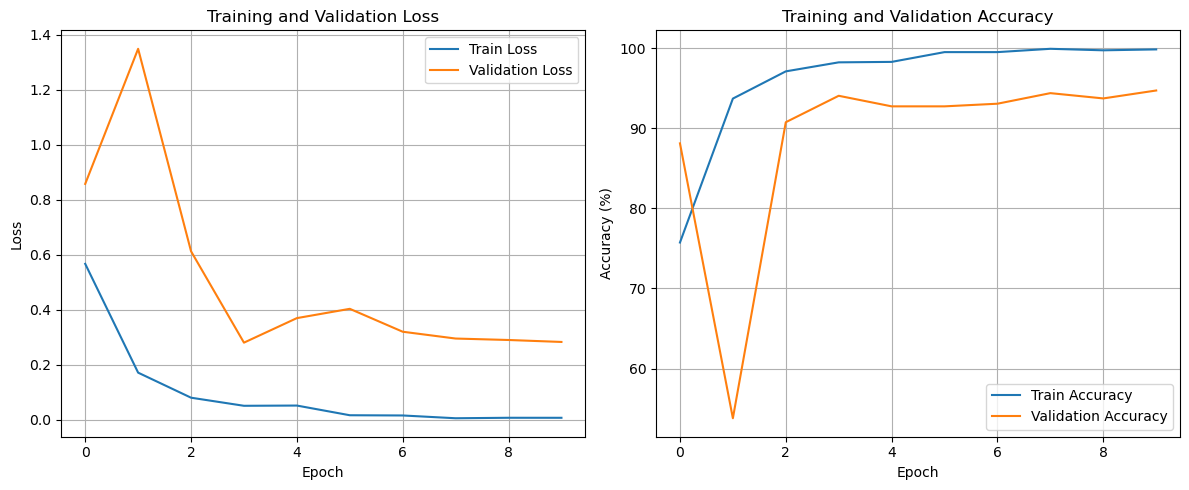

原始混淆矩阵：
      0   1  2
0  265   0  2
1    0  12  8
2    0  10  8 其中列为true label,行为predicted label


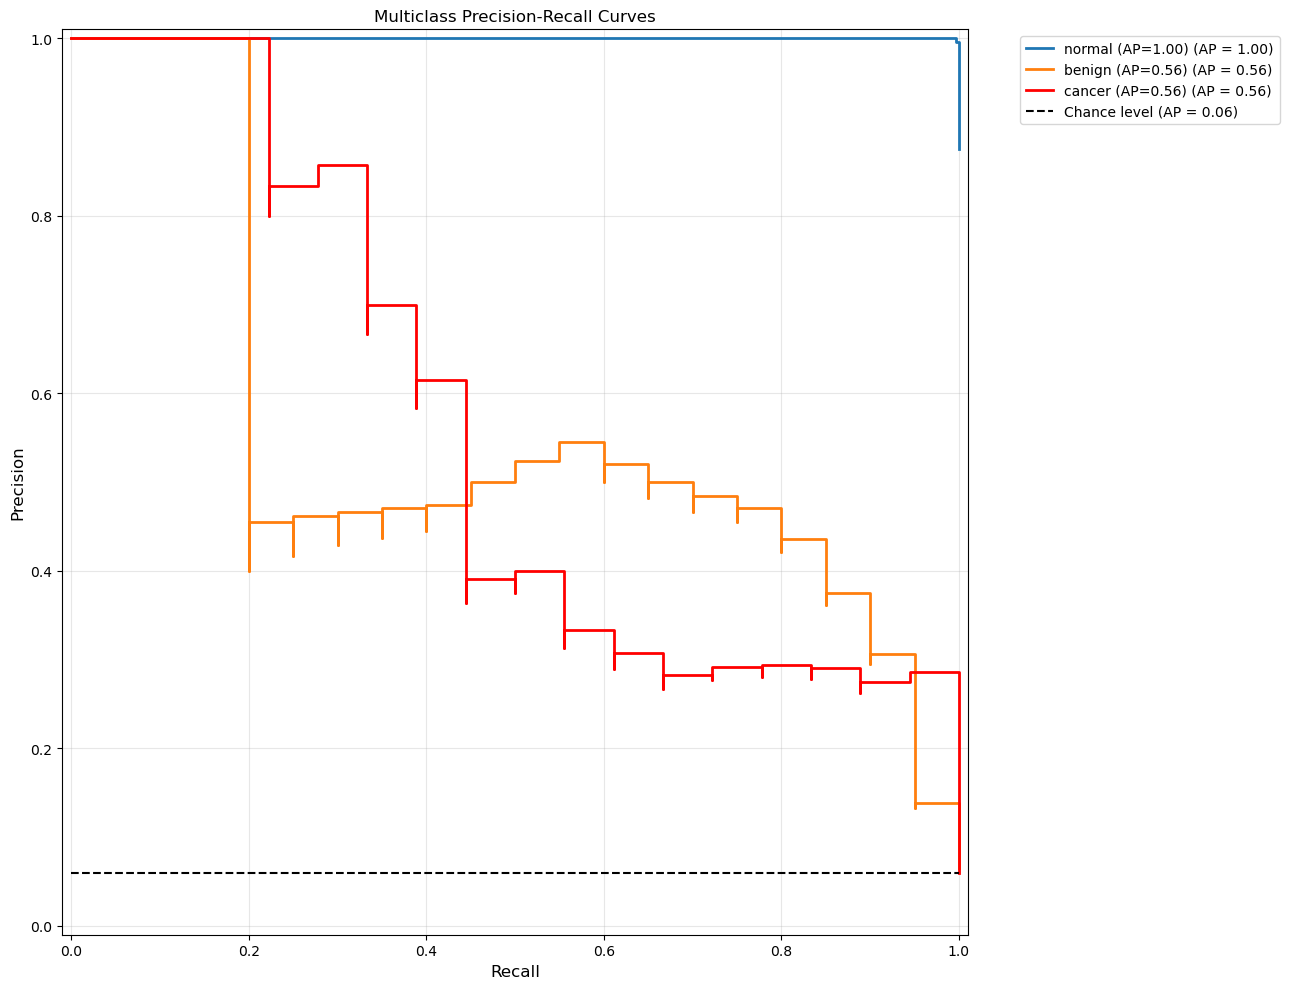

In [14]:
if __name__ == '__main__':
    main()

From the perspectives of recall and precision, the model's performance has been significantly improved, with the accuracy rate rising to 93%. From the PR curve, the recall rates of each category have also seen a notable increase. It can be seen from the confusion matrix that the prediction accuracy of the model for the cancer samples in the test set has increased to 8/18=0.44, and the recognition rate of the model for the begign samples is relatively higher, reaching 12/20=0.6. Overall, however, it is still not good enough. This might be because the number of resampling is not large enough, and the model has not learned sufficient features, resulting in overfitting and insufficient generalization ability of the model. It can be seen from the confusion matrix that cancer samples are mostly classified into the begign class. To ensure a high recognition rate of cancer samples, we can also consider using more complex model architectures or data augmentation methods to enhance the model's recognition ability for important minority categories.


Next, we attempt to use the Reweight of the loss function in the model so that each class contributes equally to the loss function;

In [14]:
### Reset to the original training set
train_dataset = CancerImageDataset(train_data)
val_dataset = CancerImageDataset(val_data)
test_dataset = CancerImageDataset(test_data)
    
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Test one batch
sample_images, sample_labels = next(iter(train_loader))
print(f"img_tensor_shape: {sample_images.shape}")  # Should be [32, 3, 224, 224]
print(f"label_tensor_shape: {sample_labels.shape}")  # Should be [32]


img_tensor_shape: torch.Size([32, 3, 256, 256])
label_tensor_shape: torch.Size([32])


In [15]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = CancerImageCNN(num_classes=3).to(device)
    
    # Define loss function and optimizer
    
    ################## Apply weighting to the loss function here
    # Extract all labels from the training dataset
    def get_all_labels(dataset):
        return [label for _, label in dataset]

    # Get all labels from the training set
    train_labels = get_all_labels(train_dataset)  # Note: using the original training set without resampling
    # If using resampled dataset, the weights would be approximately equal
    ################## Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=np.array(train_labels))
    ################## Apply weights in the loss function, note: using the original training set
    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
    #criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    ################## Use StepLR to dynamically adjust learning rate during training
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    
    # Training history records
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Training parameters
    ## Debug settings
    epochs_num = 15
    best_acc = 0.0

    # Training loop
    for epoch in range(1, epochs_num+1):
        start_time = time.time()
        
        train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
        val_loss, val_acc = evaluate(model, device, val_loader, criterion)
        scheduler.step()
        
        # Record historical data
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch}/{epochs_num} | Time: {epoch_time:.2f}s')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print('-' * 60)
    
    # Final testing
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc = evaluate(model, device, test_loader, criterion)
    print(f'\nFinal Test Performance:')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')
    
    # Plot training curves
    plot_training_curves(history)
    
    # Plot confusion matrix and recall-related metrics for predictions
    test_results = get_predictions(model, device, test_loader)
    y_true = test_results['true_labels']  # Array of true labels
    y_pred = test_results['predictions']  # Array of predicted labels
    classes = ['normal','benign','cancer']  # Class names
    cm = confusion_matrix(y_true, y_pred)  # Confusion matrix
    df_cm = pd.DataFrame(cm) 
    
    print("Original confusion matrix:\n", df_cm, "where columns are true labels and rows are predicted labels")
    
    # Plot PR curves for each class
    # Special focus on the 'cancer' class
    y_scores = test_results['probabilities']
    plot_multiclass_pr_curves(y_true, y_scores, classes, focus_class='cancer')

Using device: cuda


Train Epoch 1: 100%|██████████| 77/77 [00:18<00:00,  4.10it/s, loss=1.02, acc=59.6]


Epoch 1/15 | Time: 21.20s
Train Loss: 1.0543 | Train Acc: 59.56%
Val Loss: 0.9615 | Val Acc: 50.17%
------------------------------------------------------------


Train Epoch 2: 100%|██████████| 77/77 [00:18<00:00,  4.22it/s, loss=0.772, acc=73.2]


Epoch 2/15 | Time: 20.75s
Train Loss: 0.7968 | Train Acc: 73.16%
Val Loss: 1.0897 | Val Acc: 88.12%
------------------------------------------------------------


Train Epoch 3: 100%|██████████| 77/77 [00:18<00:00,  4.21it/s, loss=0.757, acc=70.1]


Epoch 3/15 | Time: 19.48s
Train Loss: 0.7812 | Train Acc: 70.12%
Val Loss: 1.6958 | Val Acc: 17.82%
------------------------------------------------------------


Train Epoch 4: 100%|██████████| 77/77 [00:18<00:00,  4.21it/s, loss=0.666, acc=79.4]


Epoch 4/15 | Time: 19.49s
Train Loss: 0.6872 | Train Acc: 79.37%
Val Loss: 1.2688 | Val Acc: 88.12%
------------------------------------------------------------


Train Epoch 5: 100%|██████████| 77/77 [00:18<00:00,  4.20it/s, loss=0.539, acc=81.6]


Epoch 5/15 | Time: 19.54s
Train Loss: 0.5565 | Train Acc: 81.65%
Val Loss: 0.7050 | Val Acc: 69.97%
------------------------------------------------------------


Train Epoch 6: 100%|██████████| 77/77 [00:18<00:00,  4.22it/s, loss=0.41, acc=87.4] 


Epoch 6/15 | Time: 20.71s
Train Loss: 0.4230 | Train Acc: 87.41%
Val Loss: 0.3954 | Val Acc: 89.11%
------------------------------------------------------------


Train Epoch 7: 100%|██████████| 77/77 [00:18<00:00,  4.21it/s, loss=0.336, acc=90.6]


Epoch 7/15 | Time: 19.58s
Train Loss: 0.3466 | Train Acc: 90.58%
Val Loss: 0.5878 | Val Acc: 81.85%
------------------------------------------------------------


Train Epoch 8: 100%|██████████| 77/77 [00:18<00:00,  4.12it/s, loss=0.283, acc=93.4]


Epoch 8/15 | Time: 19.92s
Train Loss: 0.2924 | Train Acc: 93.42%
Val Loss: 0.8986 | Val Acc: 65.68%
------------------------------------------------------------


Train Epoch 9: 100%|██████████| 77/77 [00:18<00:00,  4.20it/s, loss=0.237, acc=93.1]


Epoch 9/15 | Time: 20.82s
Train Loss: 0.2448 | Train Acc: 93.14%
Val Loss: 0.2797 | Val Acc: 94.06%
------------------------------------------------------------


Train Epoch 10: 100%|██████████| 77/77 [00:18<00:00,  4.22it/s, loss=0.172, acc=96]  


Epoch 10/15 | Time: 19.46s
Train Loss: 0.1776 | Train Acc: 95.98%
Val Loss: 0.6563 | Val Acc: 80.20%
------------------------------------------------------------


Train Epoch 11: 100%|██████████| 77/77 [00:18<00:00,  4.24it/s, loss=0.143, acc=97]  


Epoch 11/15 | Time: 19.37s
Train Loss: 0.1472 | Train Acc: 96.95%
Val Loss: 0.8790 | Val Acc: 90.43%
------------------------------------------------------------


Train Epoch 12: 100%|██████████| 77/77 [00:18<00:00,  4.25it/s, loss=0.108, acc=96.8]


Epoch 12/15 | Time: 19.31s
Train Loss: 0.1111 | Train Acc: 96.79%
Val Loss: 0.3715 | Val Acc: 93.07%
------------------------------------------------------------


Train Epoch 13: 100%|██████████| 77/77 [00:18<00:00,  4.19it/s, loss=0.115, acc=96.8] 


Epoch 13/15 | Time: 19.62s
Train Loss: 0.1182 | Train Acc: 96.83%
Val Loss: 0.3904 | Val Acc: 91.75%
------------------------------------------------------------


Train Epoch 14: 100%|██████████| 77/77 [00:18<00:00,  4.24it/s, loss=0.0658, acc=98.4]


Epoch 14/15 | Time: 19.35s
Train Loss: 0.0678 | Train Acc: 98.38%
Val Loss: 0.3365 | Val Acc: 94.06%
------------------------------------------------------------


Train Epoch 15: 100%|██████████| 77/77 [00:18<00:00,  4.25it/s, loss=0.0704, acc=97.6]


Epoch 15/15 | Time: 19.33s
Train Loss: 0.0726 | Train Acc: 97.56%
Val Loss: 0.3646 | Val Acc: 93.73%
------------------------------------------------------------


C:\Users\zhuanghuo\AppData\Local\Temp;\ipykernel_1460\2545209244.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Final Test Performance:
Test Loss: 0.2261 | Test Acc: 94.43%


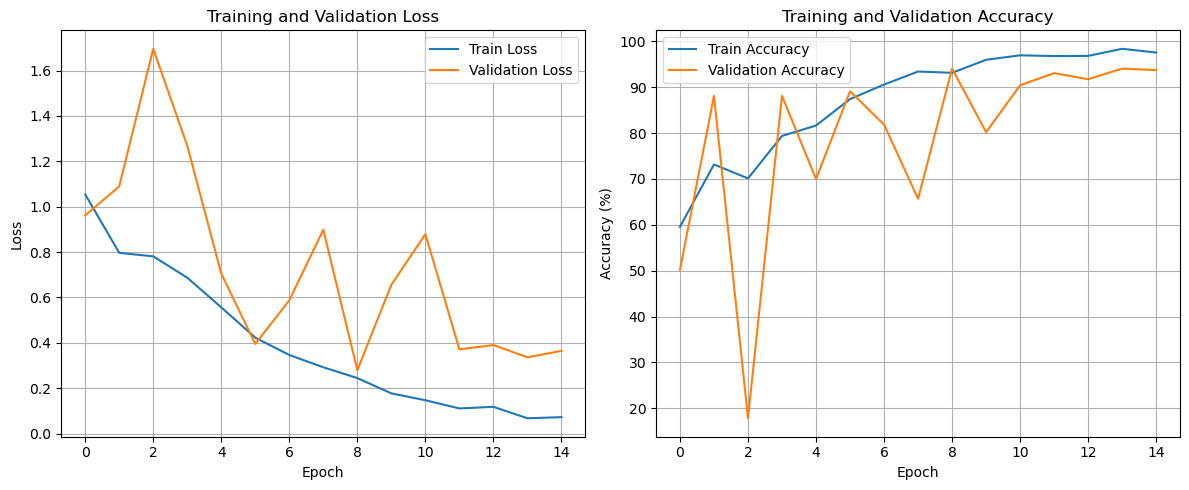

原始混淆矩阵：
      0  1   2
0  267  0   0
1    4  9   7
2    3  3  12 其中列为true label,行为predicted label


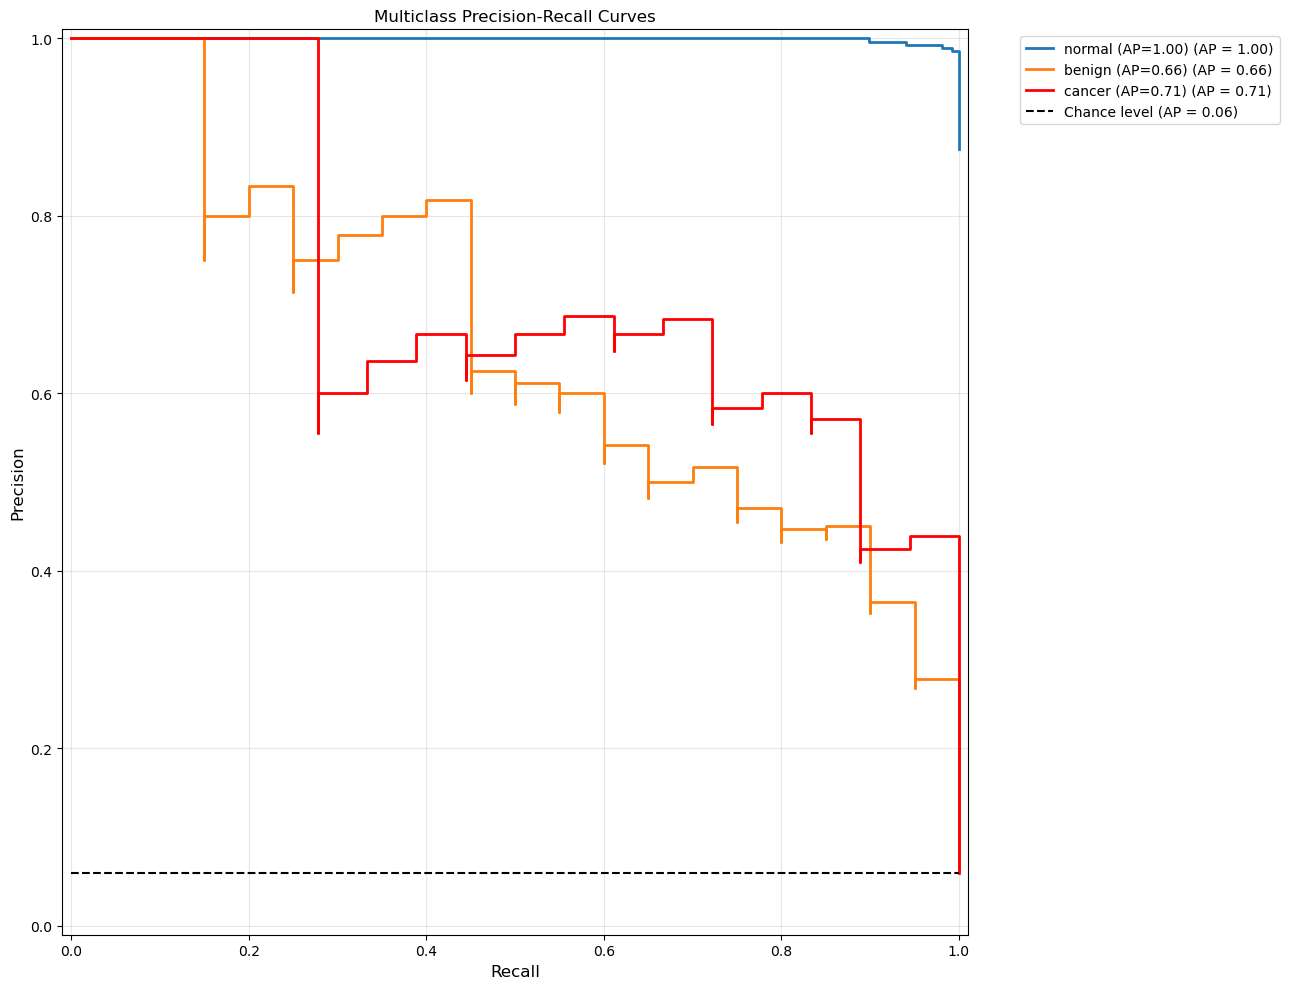

In [17]:
if __name__ == '__main__':
    main()

It can be seen that the recognition effect for a few categories has also been greatly improved compared with the original model, slightly better than the model results using oversampling. It can identify the cancer category of 12/18=0.68 and the benign category of 9/20=0.45. This is the most effective model at present.

It can be seen that both of these two methods have obvious effects. From the perspective of the confusion matrix, the recognition effect of the oversampling method for a few categories is slightly worse than that of weighting the loss function, and the recognition effect for the majority of categories is even better. So we will further fine-tune the method of using oversampling.

We will further increase the sample proportions of cancer and benign to see if the effect can be further improved. This time, we trained with the proportion of the three sample sizes basically consistent, that is, each of the three samples was around 2,000. Other parameters will not be changed.

Original sample size: cancer:132, normal:2145, benign:186

Adjusted sample size: cancer:132 *16=2112 normal:2145 benign:186 *10=1860

Meanwhile, during the fine-tuning of the model, it was observed that the modified model basically achieved a relatively high validation set accuracy rate within about five times. However, if the training continued at this point, the accuracy rate would drop sharply. This might be caused by an excessively high learning rate. Therefore, we set the step size of the scheduler to 5, and the learning rate would decrease once every five epochs. So as to find the best model.

The following is the adjusted code:

In [14]:
train_data_oversampled=create_oversampled_dataset(train_data,2,multiplier=16)
train_data_oversampled=create_oversampled_dataset(train_data_oversampled,1,multiplier=5)
train_dataset_oversampled = CancerImageDataset(train_data_oversampled)
val_dataset = CancerImageDataset(val_data)
test_dataset = CancerImageDataset(test_data)
    
#DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset_oversampled, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)



Aftrer oversampleing: Counter({0: 2145, 2: 2112, 1: 186})
Aftrer oversampleing: Counter({0: 2145, 2: 2112, 1: 930})


In [15]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = CancerImageCNN(num_classes=3).to(device)
    
    # Define the loss function and the optimizer
    
    ################## The loss function is weighted here
    # Extract all labels from the training dataset
    def get_all_labels(dataset):
        return [label for _, label in dataset]

    # Get all labels from the training set
    train_labels = get_all_labels(train_dataset)  # Note: using the original training set without resampling
    # If using resampled dataset, the weights would be approximately equal
    ################## Calculate class weights
    # class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=np.array(train_labels))
    ################## Apply weights in the loss function, note: using the original training set
    # criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    ################## Use StepLR to dynamically adjust learning rate during training
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
    

    # Training history records
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Training parameters
    
    ## Debug settings
    epochs_num = 10  # Reduced number of training epochs
    best_acc = 0.0

    # Training loop
    for epoch in range(1, epochs_num+1):
        start_time = time.time()
        
        train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
        val_loss, val_acc = evaluate(model, device, val_loader, criterion)
        scheduler.step()
        
        # Record historical data
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch}/{epochs_num} | Time: {epoch_time:.2f}s')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print('-' * 60)
    
    # Final testing
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc = evaluate(model, device, test_loader, criterion)
    print(f'\nFinal Test Performance:')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')
    
    # Plot training curves
    plot_training_curves(history)
    
    # Plot confusion matrix and recall-related metrics for predictions
    test_results = get_predictions(model, device, test_loader)
    y_true = test_results['true_labels']  # Array of true labels
    y_pred = test_results['predictions']  # Array of predicted labels
    classes = ['normal','benign','cancer']  # Class names
    cm = confusion_matrix(y_true, y_pred)  # Confusion matrix
    df_cm = pd.DataFrame(cm) 
    
    print("Original confusion matrix:\n", df_cm, "where columns are true labels and rows are predicted labels")
    
    # Plot PR curves for each class
    # Special focus on the 'cancer' class
    y_scores = test_results['probabilities']
    plot_multiclass_pr_curves(y_true, y_scores, classes, focus_class='cancer')

Using device: cuda


Train Epoch 1: 100%|██████████| 163/163 [00:38<00:00,  4.22it/s, loss=0.0564, acc=75.2]


Epoch 1/10 | Time: 41.17s
Train Loss: 0.5987 | Train Acc: 75.17%
Val Loss: 0.9157 | Val Acc: 54.79%
------------------------------------------------------------


Train Epoch 2: 100%|██████████| 163/163 [00:38<00:00,  4.29it/s, loss=0.0217, acc=91.6]


Epoch 2/10 | Time: 40.45s
Train Loss: 0.2301 | Train Acc: 91.58%
Val Loss: 0.7803 | Val Acc: 80.53%
------------------------------------------------------------


Train Epoch 3: 100%|██████████| 163/163 [00:38<00:00,  4.28it/s, loss=0.00997, acc=96.3]


Epoch 3/10 | Time: 40.55s
Train Loss: 0.1057 | Train Acc: 96.28%
Val Loss: 0.3350 | Val Acc: 91.75%
------------------------------------------------------------


Train Epoch 4: 100%|██████████| 163/163 [00:38<00:00,  4.27it/s, loss=0.0051, acc=98.8]


Epoch 4/10 | Time: 39.44s
Train Loss: 0.0541 | Train Acc: 98.82%
Val Loss: 1.5786 | Val Acc: 73.93%
------------------------------------------------------------


Train Epoch 5: 100%|██████████| 163/163 [00:38<00:00,  4.26it/s, loss=0.0116, acc=95.7]


Epoch 5/10 | Time: 40.69s
Train Loss: 0.1231 | Train Acc: 95.68%
Val Loss: 0.3098 | Val Acc: 92.41%
------------------------------------------------------------


Train Epoch 6: 100%|██████████| 163/163 [00:38<00:00,  4.26it/s, loss=0.00276, acc=99.5]


Epoch 6/10 | Time: 40.78s
Train Loss: 0.0292 | Train Acc: 99.48%
Val Loss: 0.2644 | Val Acc: 94.06%
------------------------------------------------------------


Train Epoch 7: 100%|██████████| 163/163 [00:38<00:00,  4.26it/s, loss=0.00277, acc=99.5]


Epoch 7/10 | Time: 40.73s
Train Loss: 0.0294 | Train Acc: 99.50%
Val Loss: 0.2444 | Val Acc: 94.39%
------------------------------------------------------------


Train Epoch 8: 100%|██████████| 163/163 [00:38<00:00,  4.27it/s, loss=0.00155, acc=99.7]


Epoch 8/10 | Time: 39.36s
Train Loss: 0.0164 | Train Acc: 99.73%
Val Loss: 0.2466 | Val Acc: 94.39%
------------------------------------------------------------


Train Epoch 9: 100%|██████████| 163/163 [00:37<00:00,  4.30it/s, loss=0.000924, acc=99.8]


Epoch 9/10 | Time: 40.36s
Train Loss: 0.0098 | Train Acc: 99.81%
Val Loss: 0.2912 | Val Acc: 94.72%
------------------------------------------------------------


Train Epoch 10: 100%|██████████| 163/163 [00:37<00:00,  4.30it/s, loss=0.00227, acc=99.8]


Epoch 10/10 | Time: 39.14s
Train Loss: 0.0241 | Train Acc: 99.85%
Val Loss: 0.3102 | Val Acc: 94.72%
------------------------------------------------------------


C:\Users\zhuanghuo\AppData\Local\Temp;\ipykernel_6564\3640860496.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Final Test Performance:
Test Loss: 0.3452 | Test Acc: 92.79%


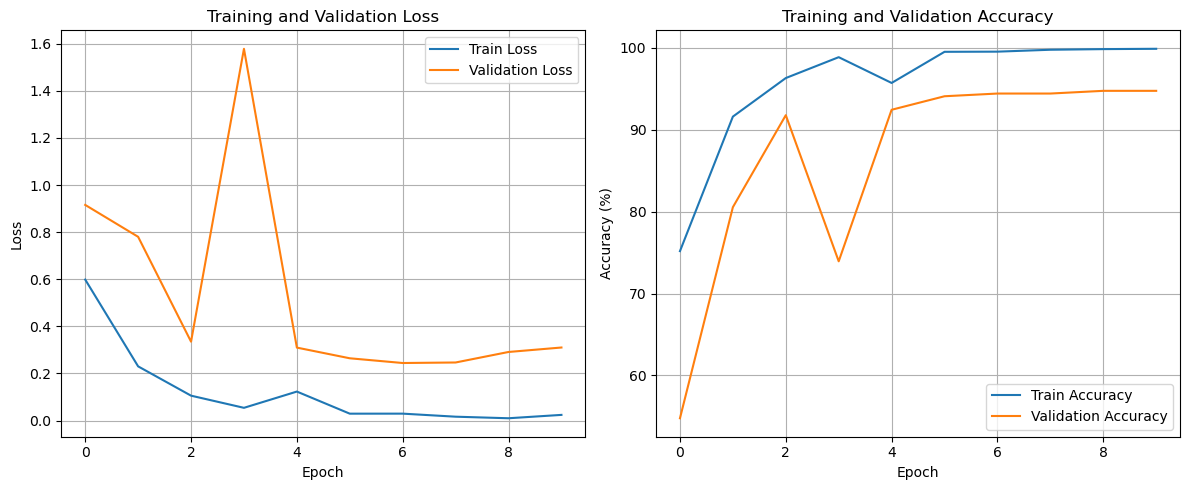

Original confusion matrix:
      0   1  2
0  263   2  2
1    1  11  8
2    0   9  9 where columns are true labels and rows are predicted labels


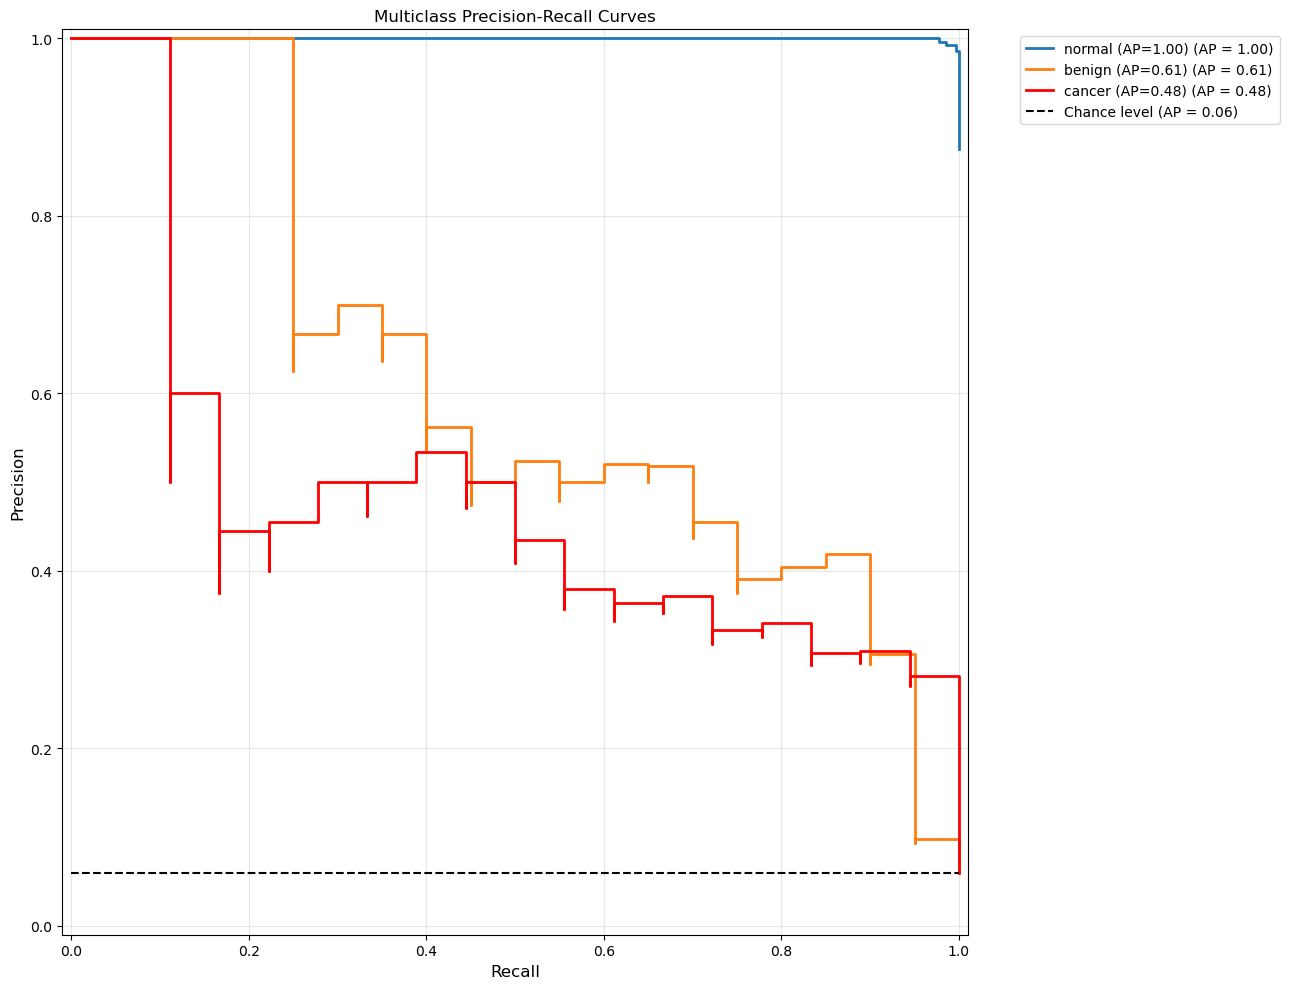

In [16]:
if __name__ == '__main__':
    main()

From the above results, the effect is acceptable. Only one sample from the test set of cancer and benign was classified into noraml. The impact of this classification error was smaller compared to the impact of not diagnosing cancer and benign. If the model is changed to a binary classification model and cancer and benign are grouped into one category with tumor lesions (without distinguishing between benign and malignant), (because when tumor lesions are detected, a biopsy is required, and the biopsy will determine whether the patient's tumor disease has become benign or malignant.) Compared with directly misclassifying cancer and benign into the normal category, the consequence of missing the treatment time due to the failure to diagnose the problems in patients would be a little better. The accuracy rate of the model would reach nearly 100%, and the recall rate would also be close to 100%.

## Q2 Implement a transfer learning model based on a pretrained model 

q2 requires us to implement a transfer learning model based on a pretrained model (e.g.,
pretrained ResNet-18) and fine-tune it in PyTorch for the classification of the clinical diseases images.  Therefore, this report selects the transfer learning model based on ResNet-18. We need to retain the parameters of each layer such as the convolutional layer, and replace the final fully connected layer with a custom output layer. Otherwise, it is fine-tuning based on the pre-trained model rather than training from scratch.

We set the input of the connection layer to 256, and the final output to category 3. The probability of the drop parameter in the dropout layer is set to 0.5.

In [18]:
from torchvision import models, transforms

class ResNet18Transfer(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet18Transfer, self).__init__()
        # Load pretrained ResNet18
        self.base_model = models.resnet18(pretrained=True)
        
        # Freeze all convolutional layer parameters
        for param in self.base_model.parameters():
            param.requires_grad = False
            
        # Replace the final fully connected layer
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.base_model(x)

model = ResNet18Transfer(num_classes=3).to(device)

e:\anna\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\anna\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


After that, we can start the training using the same dataset. First, we conduct training using the training set and test set after oversampling and balancing, and then use the test set for testing. The training process and the operations carried out are consistent with the model we trained ourselves.

In [35]:
train_data_oversampled=create_oversampled_dataset(train_data,2,multiplier=16)
train_data_oversampled=create_oversampled_dataset(train_data,1,multiplier=10)
train_dataset_oversampled = CancerImageDataset(train_data_oversampled)
val_dataset = CancerImageDataset(val_data)
test_dataset = CancerImageDataset(test_data)
    
#DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset_oversampled, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    ##### Changed to ResNet18 transfer learning model
    model = ResNet18Transfer(num_classes=3).to(device)
    
    # Define loss function and optimizer
    
    ################## Weighting the loss function here
    # Extract all labels from training dataset
    def get_all_labels(dataset):
        return [label for _, label in dataset]

    # Get all labels from training set
    #train_labels = get_all_labels(train_dataset)
    ################## Calculate class weights
    #class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=np.array(train_labels))
    ################## Apply weights in loss function
    #criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    ################## Use StepLR to dynamically adjust learning rate during training
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    

    # Training history records
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Training parameters
    
    ## Debug settings
    epochs_num = 15
    best_acc = 0.0

    # Training loop
    for epoch in range(1, epochs_num+1):
        start_time = time.time()
        
        train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
        val_loss, val_acc = evaluate(model, device, val_loader, criterion)
        scheduler.step()
        
        # Record training history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch}/{epochs_num} | Time: {epoch_time:.2f}s')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print('-' * 60)
    
    # Final testing
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc = evaluate(model, device, test_loader, criterion)
    print(f'\nFinal Test Performance:')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')
    
    # Plot training curves
    plot_training_curves(history)
    
    # Plot confusion matrix and recall metrics for predictions
    test_results = get_predictions(model, device, test_loader)
    y_true = test_results['true_labels']  # Array of true labels
    y_pred = test_results['predictions']  # Array of predicted labels
    classes = ['normal','benign','cancer']  # Class names
    cm = confusion_matrix(y_true, y_pred)  # Confusion matrix
    df_cm = pd.DataFrame(cm) 
    
    print("Original confusion matrix:\n", df_cm, "where columns are true labels and rows are predicted labels")
    
    # Plot PR curves for each class
    # Special focus on 'cancer' class
    y_scores = test_results['probabilities']
    plot_multiclass_pr_curves(y_true, y_scores, classes, focus_class='cancer')
    

Using device: cuda


Train Epoch 1: 100%|██████████| 141/141 [00:19<00:00,  7.12it/s, loss=0.441, acc=81.6]


Epoch 1/15 | Time: 21.19s
Train Loss: 0.4864 | Train Acc: 81.64%
Val Loss: 0.3649 | Val Acc: 93.40%
------------------------------------------------------------


Train Epoch 2: 100%|██████████| 141/141 [00:19<00:00,  7.27it/s, loss=0.273, acc=90.2]


Epoch 2/15 | Time: 20.69s
Train Loss: 0.3014 | Train Acc: 90.15%
Val Loss: 0.4394 | Val Acc: 91.75%
------------------------------------------------------------


Train Epoch 3: 100%|██████████| 141/141 [00:19<00:00,  7.14it/s, loss=0.236, acc=92.1]


Epoch 3/15 | Time: 21.08s
Train Loss: 0.2601 | Train Acc: 92.06%
Val Loss: 0.3347 | Val Acc: 93.40%
------------------------------------------------------------


Train Epoch 4: 100%|██████████| 141/141 [00:19<00:00,  7.18it/s, loss=0.213, acc=92.4]


Epoch 4/15 | Time: 20.99s
Train Loss: 0.2348 | Train Acc: 92.44%
Val Loss: 0.3691 | Val Acc: 93.07%
------------------------------------------------------------


Train Epoch 5: 100%|██████████| 141/141 [00:19<00:00,  7.22it/s, loss=0.185, acc=93.7]


Epoch 5/15 | Time: 20.84s
Train Loss: 0.2035 | Train Acc: 93.75%
Val Loss: 0.3415 | Val Acc: 92.41%
------------------------------------------------------------


Train Epoch 6: 100%|██████████| 141/141 [00:19<00:00,  7.23it/s, loss=0.171, acc=94]  


Epoch 6/15 | Time: 20.80s
Train Loss: 0.1891 | Train Acc: 93.97%
Val Loss: 0.3307 | Val Acc: 93.07%
------------------------------------------------------------


Train Epoch 7: 100%|██████████| 141/141 [00:19<00:00,  7.23it/s, loss=0.161, acc=94.3]


Epoch 7/15 | Time: 20.83s
Train Loss: 0.1776 | Train Acc: 94.34%
Val Loss: 0.4010 | Val Acc: 90.76%
------------------------------------------------------------


Train Epoch 8: 100%|██████████| 141/141 [00:19<00:00,  7.25it/s, loss=0.163, acc=94.4]


Epoch 8/15 | Time: 20.76s
Train Loss: 0.1803 | Train Acc: 94.39%
Val Loss: 0.3273 | Val Acc: 92.74%
------------------------------------------------------------


Train Epoch 9: 100%|██████████| 141/141 [00:19<00:00,  7.22it/s, loss=0.14, acc=95.3] 


Epoch 9/15 | Time: 20.79s
Train Loss: 0.1540 | Train Acc: 95.28%
Val Loss: 0.3436 | Val Acc: 92.74%
------------------------------------------------------------


Train Epoch 10: 100%|██████████| 141/141 [00:19<00:00,  7.23it/s, loss=0.14, acc=94.9] 


Epoch 10/15 | Time: 20.81s
Train Loss: 0.1546 | Train Acc: 94.90%
Val Loss: 0.3246 | Val Acc: 92.41%
------------------------------------------------------------


Train Epoch 11: 100%|██████████| 141/141 [00:19<00:00,  7.27it/s, loss=0.136, acc=95.3]


Epoch 11/15 | Time: 20.72s
Train Loss: 0.1503 | Train Acc: 95.30%
Val Loss: 0.3280 | Val Acc: 93.40%
------------------------------------------------------------


Train Epoch 12: 100%|██████████| 141/141 [00:19<00:00,  7.15it/s, loss=0.129, acc=95.5]


Epoch 12/15 | Time: 21.09s
Train Loss: 0.1426 | Train Acc: 95.48%
Val Loss: 0.3162 | Val Acc: 93.73%
------------------------------------------------------------


Train Epoch 13: 100%|██████████| 141/141 [00:19<00:00,  7.26it/s, loss=0.149, acc=94.7]


Epoch 13/15 | Time: 20.77s
Train Loss: 0.1638 | Train Acc: 94.74%
Val Loss: 0.3462 | Val Acc: 92.74%
------------------------------------------------------------


Train Epoch 14: 100%|██████████| 141/141 [00:19<00:00,  7.25it/s, loss=0.129, acc=95.6]


Epoch 14/15 | Time: 20.73s
Train Loss: 0.1417 | Train Acc: 95.59%
Val Loss: 0.3755 | Val Acc: 92.08%
------------------------------------------------------------


Train Epoch 15: 100%|██████████| 141/141 [00:19<00:00,  7.24it/s, loss=0.117, acc=96.1]


Epoch 15/15 | Time: 20.77s
Train Loss: 0.1288 | Train Acc: 96.05%
Val Loss: 0.2999 | Val Acc: 93.40%
------------------------------------------------------------


C:\Users\zhuanghuo\AppData\Local\Temp;\ipykernel_25372\1635607668.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Final Test Performance:
Test Loss: 0.3361 | Test Acc: 92.13%


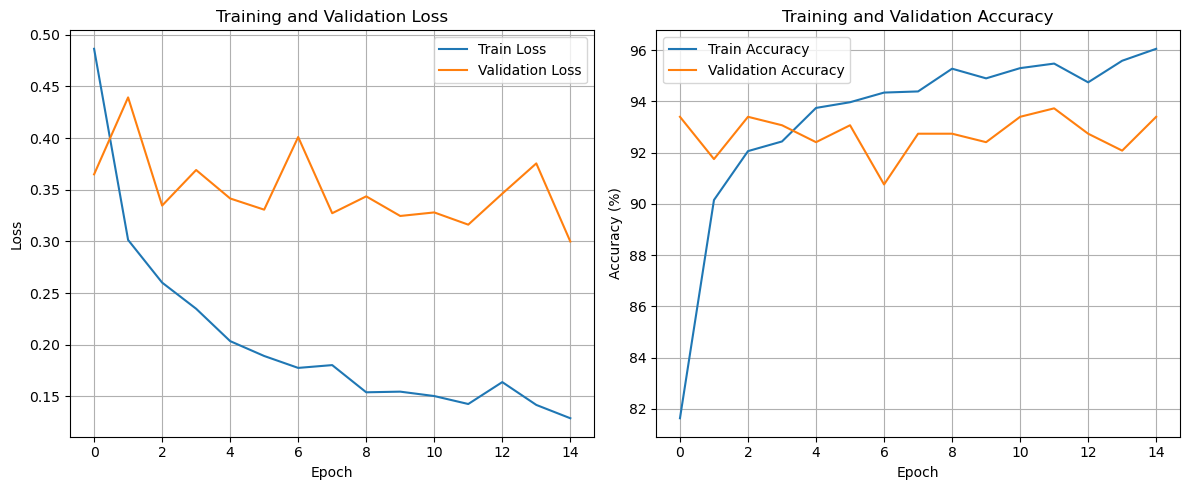

原始混淆矩阵：
      0   1  2
0  262   5  0
1    1  19  0
2    2  16  0 其中列为true label，行为predicted label


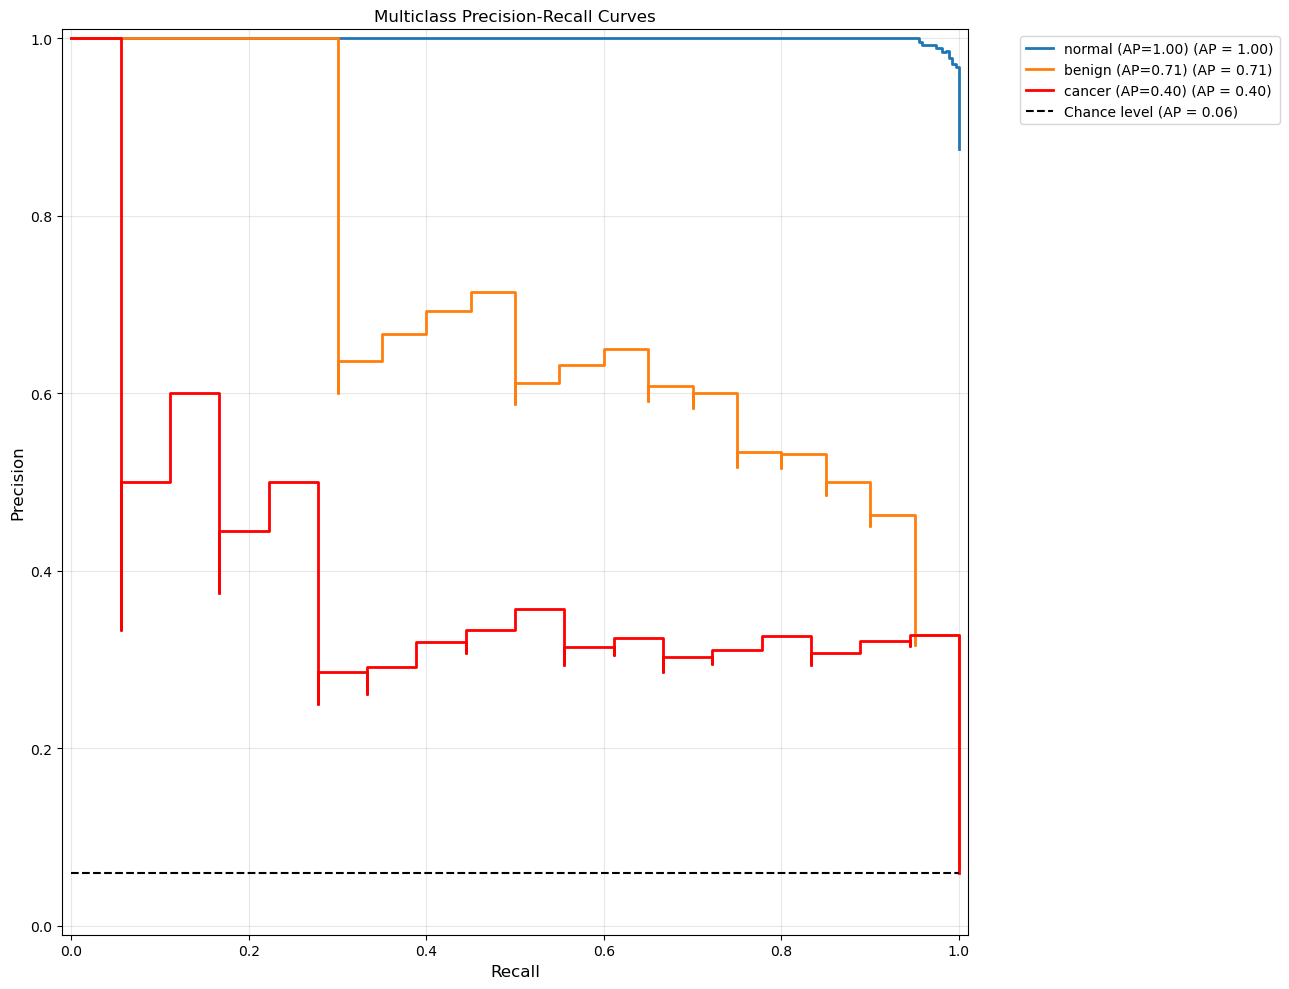

In [36]:
if __name__ == '__main__':
    main()

Using device: cuda


e:\anna\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\anna\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Train Epoch 1: 100%|██████████| 143/143 [00:20<00:00,  6.81it/s, loss=0.511, acc=79.3]


Epoch 1/15 | Time: 22.39s
Train Loss: 0.5276 | Train Acc: 79.34%
Val Loss: 0.2930 | Val Acc: 90.43%
------------------------------------------------------------


Train Epoch 2: 100%|██████████| 143/143 [00:20<00:00,  6.84it/s, loss=0.388, acc=85.6]


Epoch 2/15 | Time: 22.32s
Train Loss: 0.4002 | Train Acc: 85.57%
Val Loss: 0.3051 | Val Acc: 91.09%
------------------------------------------------------------


Train Epoch 3: 100%|██████████| 143/143 [00:20<00:00,  6.87it/s, loss=0.319, acc=88.5]


Epoch 3/15 | Time: 22.23s
Train Loss: 0.3297 | Train Acc: 88.55%
Val Loss: 0.3368 | Val Acc: 88.78%
------------------------------------------------------------


Train Epoch 4: 100%|██████████| 143/143 [00:20<00:00,  6.83it/s, loss=0.283, acc=89.9]


Epoch 4/15 | Time: 22.35s
Train Loss: 0.2916 | Train Acc: 89.90%
Val Loss: 0.3220 | Val Acc: 88.12%
------------------------------------------------------------


Train Epoch 5: 100%|██████████| 143/143 [00:20<00:00,  6.88it/s, loss=0.263, acc=90.8]


Epoch 5/15 | Time: 22.22s
Train Loss: 0.2714 | Train Acc: 90.75%
Val Loss: 0.2602 | Val Acc: 92.41%
------------------------------------------------------------


Train Epoch 6: 100%|██████████| 143/143 [00:20<00:00,  6.89it/s, loss=0.23, acc=91.7] 


Epoch 6/15 | Time: 22.11s
Train Loss: 0.2378 | Train Acc: 91.72%
Val Loss: 0.3010 | Val Acc: 90.76%
------------------------------------------------------------


Train Epoch 7: 100%|██████████| 143/143 [00:20<00:00,  7.06it/s, loss=0.2, acc=93.2]  


Epoch 7/15 | Time: 21.57s
Train Loss: 0.2063 | Train Acc: 93.18%
Val Loss: 0.2772 | Val Acc: 91.75%
------------------------------------------------------------


Train Epoch 8: 100%|██████████| 143/143 [00:20<00:00,  7.11it/s, loss=0.201, acc=93.3]


Epoch 8/15 | Time: 21.43s
Train Loss: 0.2070 | Train Acc: 93.27%
Val Loss: 0.2585 | Val Acc: 91.75%
------------------------------------------------------------


Train Epoch 9: 100%|██████████| 143/143 [00:20<00:00,  7.09it/s, loss=0.193, acc=93]  


Epoch 9/15 | Time: 21.49s
Train Loss: 0.1997 | Train Acc: 93.05%
Val Loss: 0.2503 | Val Acc: 90.76%
------------------------------------------------------------


Train Epoch 10: 100%|██████████| 143/143 [00:20<00:00,  7.13it/s, loss=0.183, acc=93.2]


Epoch 10/15 | Time: 21.37s
Train Loss: 0.1884 | Train Acc: 93.22%
Val Loss: 0.3243 | Val Acc: 90.10%
------------------------------------------------------------


Train Epoch 11: 100%|██████████| 143/143 [00:20<00:00,  7.11it/s, loss=0.172, acc=94.1]


Epoch 11/15 | Time: 21.46s
Train Loss: 0.1780 | Train Acc: 94.05%
Val Loss: 0.2408 | Val Acc: 91.42%
------------------------------------------------------------


Train Epoch 12: 100%|██████████| 143/143 [00:20<00:00,  7.12it/s, loss=0.156, acc=94.7]


Epoch 12/15 | Time: 21.47s
Train Loss: 0.1610 | Train Acc: 94.73%
Val Loss: 0.2558 | Val Acc: 91.42%
------------------------------------------------------------


Train Epoch 13: 100%|██████████| 143/143 [00:19<00:00,  7.19it/s, loss=0.138, acc=95.2]


Epoch 13/15 | Time: 21.21s
Train Loss: 0.1421 | Train Acc: 95.19%
Val Loss: 0.2598 | Val Acc: 90.76%
------------------------------------------------------------


Train Epoch 14: 100%|██████████| 143/143 [00:19<00:00,  7.20it/s, loss=0.144, acc=94.9]


Epoch 14/15 | Time: 21.19s
Train Loss: 0.1488 | Train Acc: 94.91%
Val Loss: 0.2890 | Val Acc: 90.43%
------------------------------------------------------------


Train Epoch 15: 100%|██████████| 143/143 [00:19<00:00,  7.19it/s, loss=0.147, acc=95.1]


Epoch 15/15 | Time: 21.24s
Train Loss: 0.1516 | Train Acc: 95.13%
Val Loss: 0.2484 | Val Acc: 91.75%
------------------------------------------------------------


C:\Users\zhuanghuo\AppData\Local\Temp;\ipykernel_25372\1635607668.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Final Test Performance:
Test Loss: 0.2662 | Test Acc: 88.85%


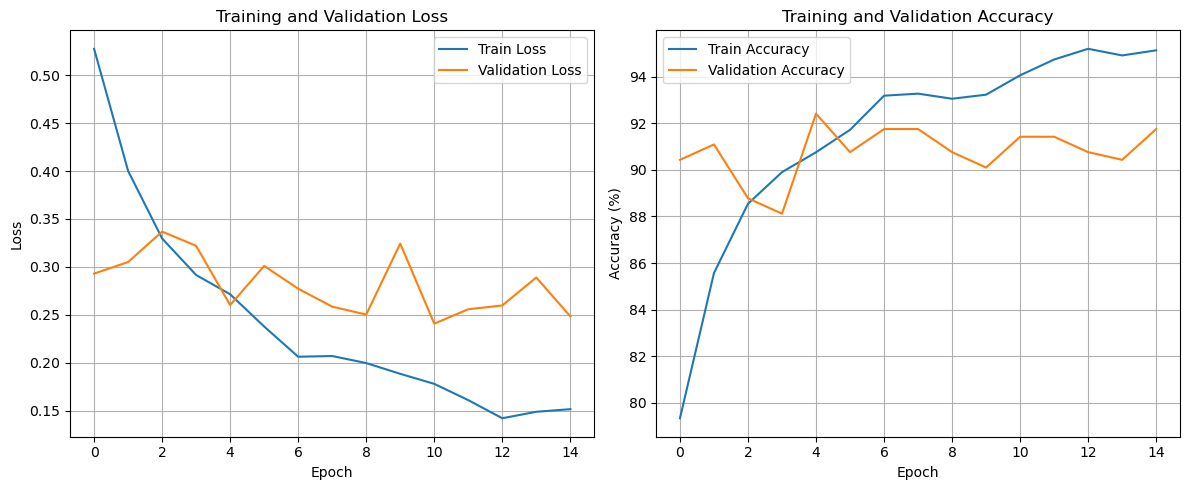

原始混淆矩阵：
      0  1   2
0  256  0  11
1    3  0  17
2    3  0  15 其中列为true label，行为predicted label


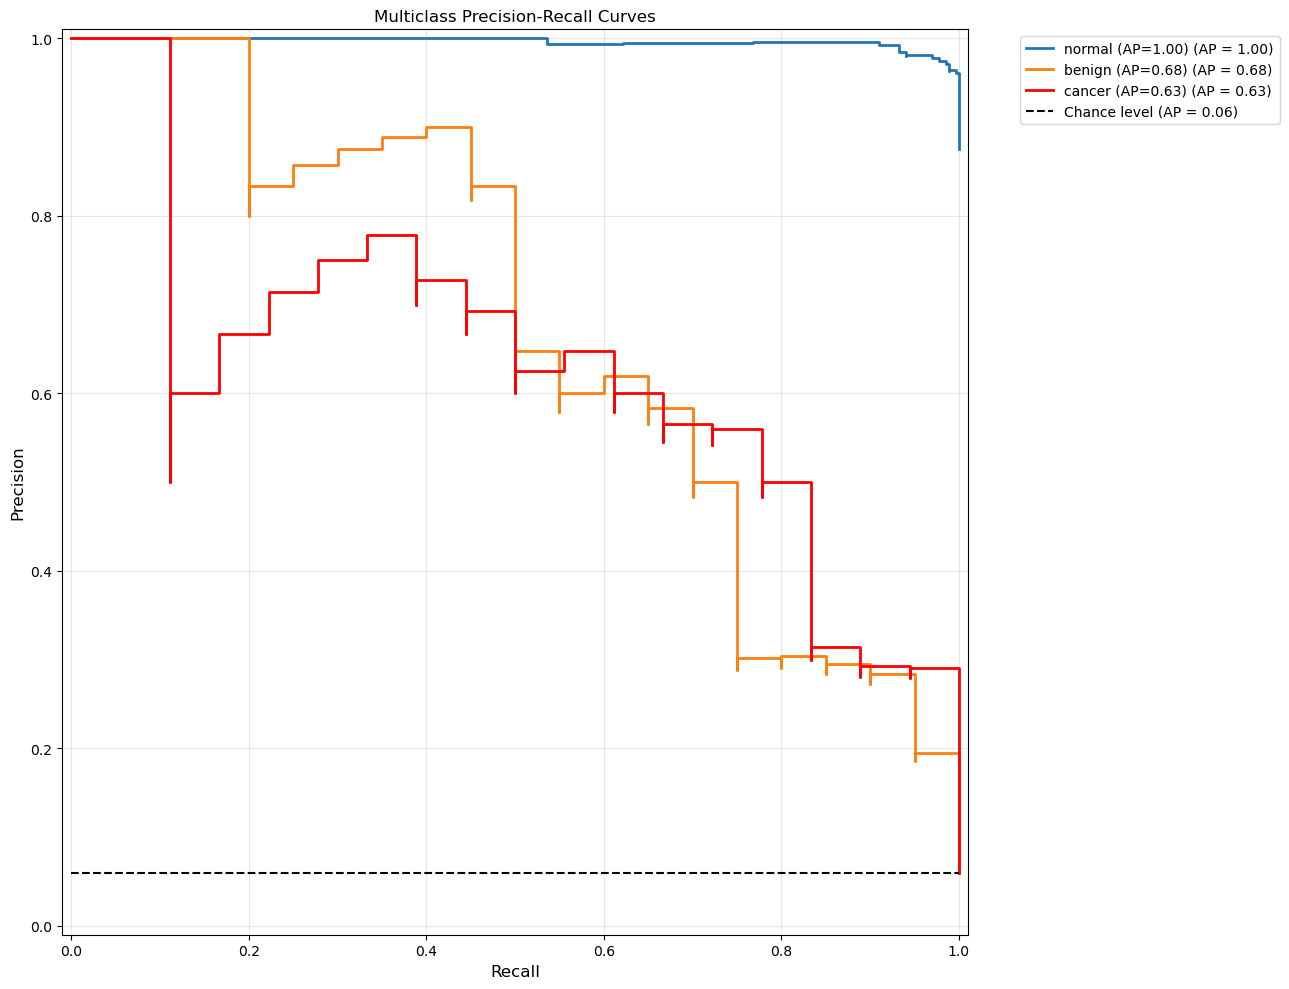

In [40]:
train_data_oversampled=create_oversampled_dataset(train_data,2,multiplier=16)
train_dataset_oversampled = CancerImageDataset(train_data_oversampled)
val_dataset = CancerImageDataset(val_data)
test_dataset = CancerImageDataset(test_data)
    
#DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset_oversampled, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

if __name__ == '__main__':
    main()

It can be seen from the confusion matrix that the model has overfitted cancer again at this time, predicting all the benign samples as cancer. 

Next, we will reduce the number of cancer samples for testing.

Using device: cuda


e:\anna\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\anna\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Train Epoch 1: 100%|██████████| 98/98 [00:14<00:00,  6.94it/s, loss=0.354, acc=76.8]


Epoch 1/15 | Time: 15.55s
Train Loss: 0.5946 | Train Acc: 76.82%
Val Loss: 0.3632 | Val Acc: 90.10%
------------------------------------------------------------


Train Epoch 2: 100%|██████████| 98/98 [00:13<00:00,  7.03it/s, loss=0.246, acc=84.9]


Epoch 2/15 | Time: 15.31s
Train Loss: 0.4131 | Train Acc: 84.89%
Val Loss: 0.2770 | Val Acc: 91.42%
------------------------------------------------------------


Train Epoch 3: 100%|██████████| 98/98 [00:13<00:00,  7.05it/s, loss=0.235, acc=85]  


Epoch 3/15 | Time: 15.20s
Train Loss: 0.3949 | Train Acc: 84.98%
Val Loss: 0.2654 | Val Acc: 91.42%
------------------------------------------------------------


Train Epoch 4: 100%|██████████| 98/98 [00:13<00:00,  7.08it/s, loss=0.19, acc=88.2] 


Epoch 4/15 | Time: 15.26s
Train Loss: 0.3188 | Train Acc: 88.25%
Val Loss: 0.2590 | Val Acc: 90.76%
------------------------------------------------------------


Train Epoch 5: 100%|██████████| 98/98 [00:13<00:00,  7.08it/s, loss=0.184, acc=88.1]


Epoch 5/15 | Time: 15.16s
Train Loss: 0.3082 | Train Acc: 88.09%
Val Loss: 0.3164 | Val Acc: 89.11%
------------------------------------------------------------


Train Epoch 6: 100%|██████████| 98/98 [00:13<00:00,  7.18it/s, loss=0.153, acc=90.6]


Epoch 6/15 | Time: 15.03s
Train Loss: 0.2565 | Train Acc: 90.62%
Val Loss: 0.2392 | Val Acc: 92.08%
------------------------------------------------------------


Train Epoch 7: 100%|██████████| 98/98 [00:13<00:00,  7.16it/s, loss=0.149, acc=91]  


Epoch 7/15 | Time: 14.97s
Train Loss: 0.2502 | Train Acc: 91.00%
Val Loss: 0.2254 | Val Acc: 91.75%
------------------------------------------------------------


Train Epoch 8: 100%|██████████| 98/98 [00:13<00:00,  7.18it/s, loss=0.157, acc=90.2]


Epoch 8/15 | Time: 14.95s
Train Loss: 0.2629 | Train Acc: 90.23%
Val Loss: 0.2636 | Val Acc: 91.09%
------------------------------------------------------------


Train Epoch 9: 100%|██████████| 98/98 [00:13<00:00,  7.17it/s, loss=0.146, acc=90.7]


Epoch 9/15 | Time: 14.95s
Train Loss: 0.2452 | Train Acc: 90.68%
Val Loss: 0.2196 | Val Acc: 91.75%
------------------------------------------------------------


Train Epoch 10: 100%|██████████| 98/98 [00:13<00:00,  7.13it/s, loss=0.132, acc=91.8]


Epoch 10/15 | Time: 15.06s
Train Loss: 0.2217 | Train Acc: 91.83%
Val Loss: 0.2228 | Val Acc: 90.76%
------------------------------------------------------------


Train Epoch 11: 100%|██████████| 98/98 [00:13<00:00,  7.16it/s, loss=0.124, acc=91.6]


Epoch 11/15 | Time: 15.01s
Train Loss: 0.2087 | Train Acc: 91.61%
Val Loss: 0.2140 | Val Acc: 91.75%
------------------------------------------------------------


Train Epoch 12: 100%|██████████| 98/98 [00:13<00:00,  7.04it/s, loss=0.118, acc=92.3]


Epoch 12/15 | Time: 15.23s
Train Loss: 0.1982 | Train Acc: 92.32%
Val Loss: 0.2257 | Val Acc: 91.42%
------------------------------------------------------------


Train Epoch 13: 100%|██████████| 98/98 [00:13<00:00,  7.10it/s, loss=0.12, acc=92.4] 


Epoch 13/15 | Time: 15.11s
Train Loss: 0.2008 | Train Acc: 92.41%
Val Loss: 0.2219 | Val Acc: 91.75%
------------------------------------------------------------


Train Epoch 14: 100%|██████████| 98/98 [00:13<00:00,  7.20it/s, loss=0.12, acc=92.4] 


Epoch 14/15 | Time: 15.00s
Train Loss: 0.2008 | Train Acc: 92.38%
Val Loss: 0.2148 | Val Acc: 92.41%
------------------------------------------------------------


Train Epoch 15: 100%|██████████| 98/98 [00:13<00:00,  7.11it/s, loss=0.116, acc=92.9]


Epoch 15/15 | Time: 15.09s
Train Loss: 0.1943 | Train Acc: 92.92%
Val Loss: 0.2530 | Val Acc: 91.09%
------------------------------------------------------------


C:\Users\zhuanghuo\AppData\Local\Temp;\ipykernel_25372\1635607668.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Final Test Performance:
Test Loss: 0.2216 | Test Acc: 91.80%


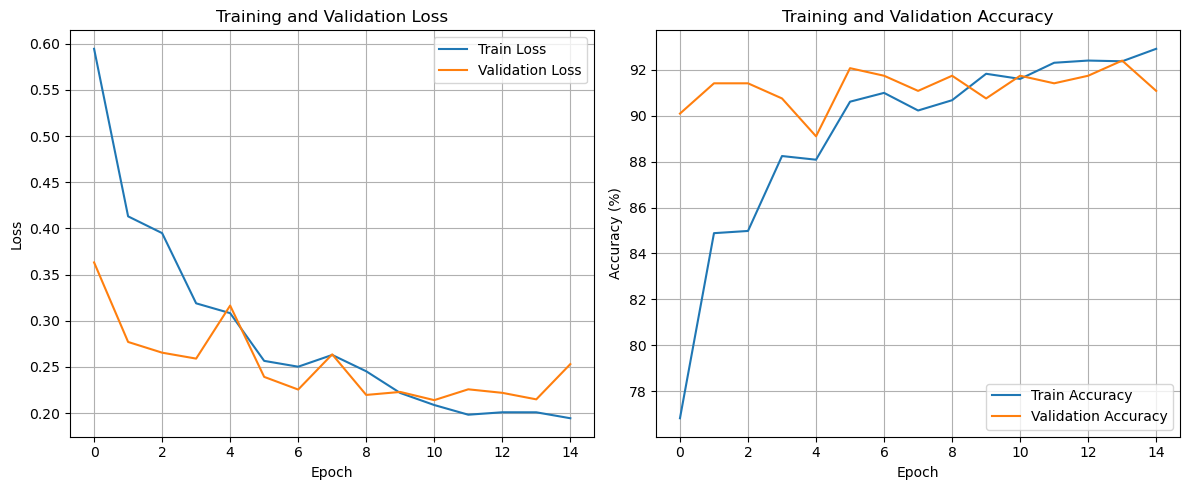

原始混淆矩阵：
      0  1   2
0  259  0   8
1    2  7  11
2    3  1  14 其中列为true label，行为predicted label


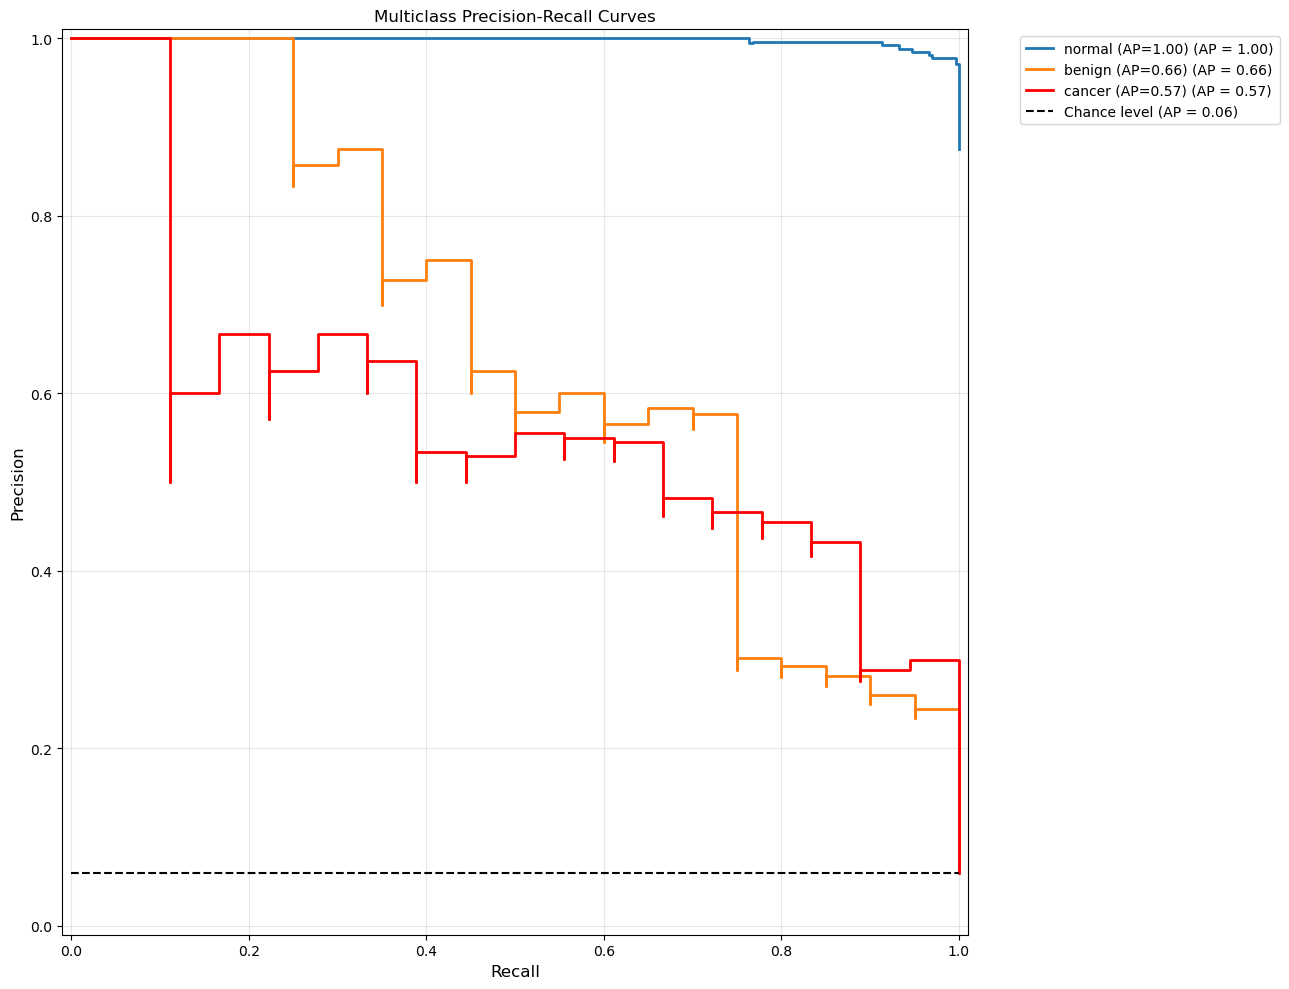

In [41]:
train_data_oversampled=create_oversampled_dataset(train_data,2,multiplier=5)
train_dataset_oversampled = CancerImageDataset(train_data_oversampled)
val_dataset = CancerImageDataset(val_data)
test_dataset = CancerImageDataset(test_data)
    
#DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset_oversampled, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

if __name__ == '__main__':
    main()

By balancing the adjustment of oversampling multiples, we obtained a superior model. This model has a good classification effect on cancer, with an accuracy rate of 78%, and the total accuracy rate on the test set reaches 91%. Compared with the previous model comparison, the accuracy rate of benign has also increased, reaching 50%. However, the overall effect of improving the minority classes through oversampling is not as good as that of the model we designed ourselves
After that, we will test the loss function by weighting it.

In [50]:
# Reset to the original training datasets
train_dataset = CancerImageDataset(train_data)
val_dataset = CancerImageDataset(val_data)
test_dataset = CancerImageDataset(test_data)
    
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Test one batch of data
sample_images, sample_labels = next(iter(train_loader))
print(f"img_tensor_shape: {sample_images.shape}")  # Expected shape: [32, 3, 224, 224]
print(f"label_tensor_shape: {sample_labels.shape}")  # Expected shape: [32]

img_tensor_shape: torch.Size([32, 3, 256, 256])
label_tensor_shape: torch.Size([32])


Using device: cuda


Train Epoch 1: 100%|██████████| 77/77 [00:11<00:00,  6.89it/s, loss=1.06, acc=61.4]


Epoch 1/15 | Time: 12.57s
Train Loss: 1.0944 | Train Acc: 61.39%
Val Loss: 0.5573 | Val Acc: 90.10%
------------------------------------------------------------


Train Epoch 2: 100%|██████████| 77/77 [00:10<00:00,  7.01it/s, loss=0.841, acc=77]  


Epoch 2/15 | Time: 12.40s
Train Loss: 0.8674 | Train Acc: 76.98%
Val Loss: 0.4416 | Val Acc: 90.76%
------------------------------------------------------------


Train Epoch 3: 100%|██████████| 77/77 [00:11<00:00,  6.99it/s, loss=0.732, acc=80.3]


Epoch 3/15 | Time: 12.34s
Train Loss: 0.7550 | Train Acc: 80.27%
Val Loss: 0.5031 | Val Acc: 82.18%
------------------------------------------------------------


Train Epoch 4: 100%|██████████| 77/77 [00:11<00:00,  6.93it/s, loss=0.678, acc=83.1]


Epoch 4/15 | Time: 12.40s
Train Loss: 0.6993 | Train Acc: 83.07%
Val Loss: 0.3447 | Val Acc: 88.78%
------------------------------------------------------------


Train Epoch 5: 100%|██████████| 77/77 [00:10<00:00,  7.06it/s, loss=0.654, acc=84]  


Epoch 5/15 | Time: 12.34s
Train Loss: 0.6749 | Train Acc: 83.96%
Val Loss: 0.3054 | Val Acc: 91.42%
------------------------------------------------------------


Train Epoch 6: 100%|██████████| 77/77 [00:11<00:00,  6.98it/s, loss=0.602, acc=86.8]


Epoch 6/15 | Time: 12.35s
Train Loss: 0.6217 | Train Acc: 86.85%
Val Loss: 0.3054 | Val Acc: 91.09%
------------------------------------------------------------


Train Epoch 7: 100%|██████████| 77/77 [00:10<00:00,  7.05it/s, loss=0.554, acc=88.2]


Epoch 7/15 | Time: 12.27s
Train Loss: 0.5718 | Train Acc: 88.23%
Val Loss: 0.3199 | Val Acc: 90.43%
------------------------------------------------------------


Train Epoch 8: 100%|██████████| 77/77 [00:11<00:00,  6.98it/s, loss=0.549, acc=88.4]


Epoch 8/15 | Time: 12.36s
Train Loss: 0.5660 | Train Acc: 88.39%
Val Loss: 0.3496 | Val Acc: 89.11%
------------------------------------------------------------


Train Epoch 9: 100%|██████████| 77/77 [00:10<00:00,  7.05it/s, loss=0.51, acc=89.1] 


Epoch 9/15 | Time: 12.31s
Train Loss: 0.5261 | Train Acc: 89.12%
Val Loss: 0.2670 | Val Acc: 91.75%
------------------------------------------------------------


Train Epoch 10: 100%|██████████| 77/77 [00:10<00:00,  7.01it/s, loss=0.521, acc=89.4]


Epoch 10/15 | Time: 12.32s
Train Loss: 0.5371 | Train Acc: 89.36%
Val Loss: 0.3375 | Val Acc: 88.78%
------------------------------------------------------------


Train Epoch 11: 100%|██████████| 77/77 [00:10<00:00,  7.06it/s, loss=0.498, acc=89.6]


Epoch 11/15 | Time: 12.20s
Train Loss: 0.5141 | Train Acc: 89.57%
Val Loss: 0.2936 | Val Acc: 91.75%
------------------------------------------------------------


Train Epoch 12: 100%|██████████| 77/77 [00:10<00:00,  7.04it/s, loss=0.495, acc=89.9]


Epoch 12/15 | Time: 12.24s
Train Loss: 0.5107 | Train Acc: 89.93%
Val Loss: 0.2827 | Val Acc: 91.09%
------------------------------------------------------------


Train Epoch 13: 100%|██████████| 77/77 [00:11<00:00,  6.92it/s, loss=0.481, acc=89.9]


Epoch 13/15 | Time: 12.45s
Train Loss: 0.4965 | Train Acc: 89.89%
Val Loss: 0.2869 | Val Acc: 91.09%
------------------------------------------------------------


Train Epoch 14: 100%|██████████| 77/77 [00:11<00:00,  6.94it/s, loss=0.484, acc=90]  


Epoch 14/15 | Time: 12.42s
Train Loss: 0.4995 | Train Acc: 90.01%
Val Loss: 0.3175 | Val Acc: 90.10%
------------------------------------------------------------


Train Epoch 15: 100%|██████████| 77/77 [00:10<00:00,  7.05it/s, loss=0.466, acc=91.6]


Epoch 15/15 | Time: 12.23s
Train Loss: 0.4805 | Train Acc: 91.60%
Val Loss: 0.3074 | Val Acc: 90.76%
------------------------------------------------------------


C:\Users\zhuanghuo\AppData\Local\Temp;\ipykernel_25372\2827098649.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Final Test Performance:
Test Loss: 0.3262 | Test Acc: 87.87%


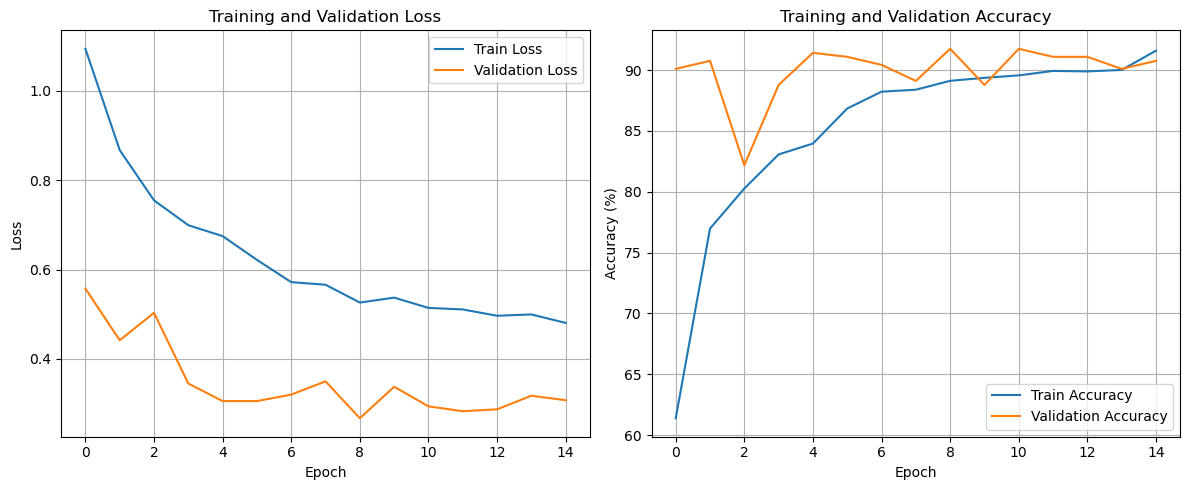

原始混淆矩阵：
      0   1  2
0  249   9  9
1    1  13  6
2    3   9  6 其中列为true label,行为predicted label


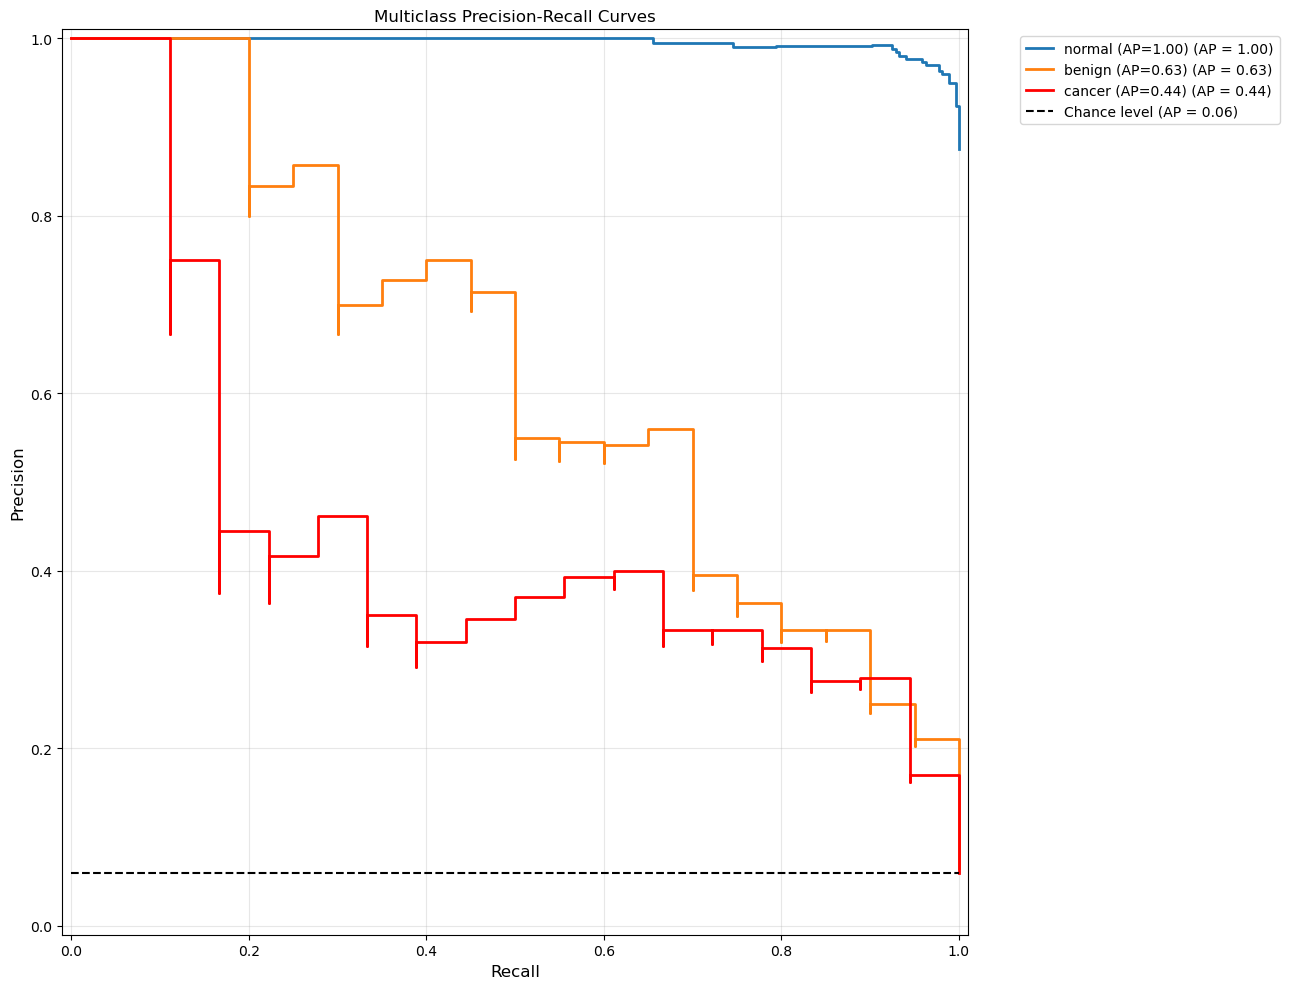

In [51]:
from sklearn.utils.class_weight import compute_class_weight

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = ResNet18Transfer(num_classes=3).to(device)
    
    # Define loss function and optimizer
    
    ################## Apply class weighting to loss function
    # Extract all labels from training dataset
    def get_all_labels(dataset):
        return [label for _, label in dataset]

    # Get all labels from training set
    train_labels = get_all_labels(train_dataset)  # Note: using original non-resampled training set
    # If using resampled dataset, the weights would be approximately equal
    ################## Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=np.array(train_labels))
    ################## Apply weights in loss function (using original non-resampled set)
    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
    #criterion = nn.CrossEntropyLoss()  # Unweighted alternative
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    ################## Use StepLR for dynamic learning rate adjustment
    scheduler = StepLR(optimizer, step_size=3, gamma=0.5)
    
    # Training history records
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Training parameters
    ## Debug settings
    epochs_num = 15
    best_acc = 0.0

    # Training loop
    for epoch in range(1, epochs_num+1):
        start_time = time.time()
        
        train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
        val_loss, val_acc = evaluate(model, device, val_loader, criterion)
        scheduler.step()
        
        # Record training metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch}/{epochs_num} | Time: {epoch_time:.2f}s')
        print(f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}%')
        print(f'Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%')
        print('-' * 60)
    
    # Final evaluation
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc = evaluate(model, device, test_loader, criterion)
    print(f'\nFinal Test Performance:')
    print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%')
    
    # Plot training curves
    plot_training_curves(history)
    
    # Generate and analyze prediction results
    test_results = get_predictions(model, device, test_loader)
    y_true = test_results['true_labels']  # Ground truth labels
    y_pred = test_results['predictions']  # Predicted labels
    classes = ['normal','benign','cancer']  # Class names
    cm = confusion_matrix(y_true, y_pred)  # Confusion matrix
    df_cm = pd.DataFrame(cm) 
    
    print("Confusion Matrix:\n", df_cm, "where columns are true labels and rows are predicted labels")
    
    # Plot PR curves for each class
    # Special focus on 'cancer' class
    y_scores = test_results['probabilities']
    plot_multiclass_pr_curves(y_true, y_scores, classes, focus_class='cancer')

if __name__ == '__main__':
    main()

It can be seen from the above results that, under the condition that other treatments are consistent, the training results using ResNet18TransferzuNet are slightly worse than those of the self-written model. There is also a deficiency in the recognition and classification of a few categories. Only 33% of cancers in the training set were successfully recognized. The recognition level of the benign category is acceptable, reaching 65%. From the precision-recall curve, the recall rate of ResNet18TransferzuNet is slightly worse than that of the model we have debugged ourselves. This indicates that we need to enhance ResNet18TransferzuNet from other perspectives. Finally, let's take a look at the results of ResNet18 without any processing to find out some reasons.

img_tensor_shape: torch.Size([32, 3, 256, 256])
label_tensor_shape: torch.Size([32])
Using device: cuda


e:\anna\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\anna\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Train Epoch 1: 100%|██████████| 77/77 [00:11<00:00,  6.71it/s, loss=1.03, acc=62.2]


Epoch 1/15 | Time: 12.88s
Train Loss: 1.0578 | Train Accuracy: 62.16%
Validation Loss: 0.9728 | Validation Accuracy: 48.18%
------------------------------------------------------------


Train Epoch 2: 100%|██████████| 77/77 [00:10<00:00,  7.09it/s, loss=0.83, acc=75.8] 


Epoch 2/15 | Time: 12.23s
Train Loss: 0.8567 | Train Accuracy: 75.76%
Validation Loss: 0.5352 | Validation Accuracy: 84.82%
------------------------------------------------------------


Train Epoch 3: 100%|██████████| 77/77 [00:10<00:00,  7.10it/s, loss=0.774, acc=77.3]


Epoch 3/15 | Time: 12.17s
Train Loss: 0.7989 | Train Accuracy: 77.34%
Validation Loss: 0.7027 | Validation Accuracy: 72.94%
------------------------------------------------------------


Train Epoch 4: 100%|██████████| 77/77 [00:10<00:00,  7.08it/s, loss=0.685, acc=81.8]


Epoch 4/15 | Time: 12.23s
Train Loss: 0.7065 | Train Accuracy: 81.81%
Validation Loss: 0.4052 | Validation Accuracy: 89.11%
------------------------------------------------------------


Train Epoch 5: 100%|██████████| 77/77 [00:10<00:00,  7.02it/s, loss=0.65, acc=83.8] 


Epoch 5/15 | Time: 12.31s
Train Loss: 0.6707 | Train Accuracy: 83.84%
Validation Loss: 0.3553 | Validation Accuracy: 90.76%
------------------------------------------------------------


Train Epoch 6: 100%|██████████| 77/77 [00:10<00:00,  7.10it/s, loss=0.64, acc=86.9] 


Epoch 6/15 | Time: 12.14s
Train Loss: 0.6602 | Train Accuracy: 86.89%
Validation Loss: 0.4433 | Validation Accuracy: 86.80%
------------------------------------------------------------


Train Epoch 7: 100%|██████████| 77/77 [00:10<00:00,  7.08it/s, loss=0.621, acc=85.1]


Epoch 7/15 | Time: 12.14s
Train Loss: 0.6410 | Train Accuracy: 85.06%
Validation Loss: 0.4026 | Validation Accuracy: 88.45%
------------------------------------------------------------


Train Epoch 8: 100%|██████████| 77/77 [00:10<00:00,  7.05it/s, loss=0.614, acc=86.7]


Epoch 8/15 | Time: 12.22s
Train Loss: 0.6339 | Train Accuracy: 86.72%
Validation Loss: 0.3639 | Validation Accuracy: 90.76%
------------------------------------------------------------


Train Epoch 9: 100%|██████████| 77/77 [00:11<00:00,  6.96it/s, loss=0.615, acc=87.6]


Epoch 9/15 | Time: 12.35s
Train Loss: 0.6341 | Train Accuracy: 87.58%
Validation Loss: 0.3886 | Validation Accuracy: 89.77%
------------------------------------------------------------


Train Epoch 10: 100%|██████████| 77/77 [00:10<00:00,  7.07it/s, loss=0.64, acc=85.6] 


Epoch 10/15 | Time: 12.16s
Train Loss: 0.6603 | Train Accuracy: 85.63%
Validation Loss: 0.4086 | Validation Accuracy: 88.45%
------------------------------------------------------------


Train Epoch 11: 100%|██████████| 77/77 [00:10<00:00,  7.00it/s, loss=0.608, acc=86.9]


Epoch 11/15 | Time: 12.29s
Train Loss: 0.6273 | Train Accuracy: 86.93%
Validation Loss: 0.3916 | Validation Accuracy: 90.10%
------------------------------------------------------------


Train Epoch 12: 100%|██████████| 77/77 [00:10<00:00,  7.10it/s, loss=0.63, acc=86]   


Epoch 12/15 | Time: 12.12s
Train Loss: 0.6498 | Train Accuracy: 85.95%
Validation Loss: 0.3976 | Validation Accuracy: 89.44%
------------------------------------------------------------


Train Epoch 13: 100%|██████████| 77/77 [00:10<00:00,  7.11it/s, loss=0.623, acc=86.1]


Epoch 13/15 | Time: 12.11s
Train Loss: 0.6433 | Train Accuracy: 86.07%
Validation Loss: 0.3750 | Validation Accuracy: 90.76%
------------------------------------------------------------


Train Epoch 14: 100%|██████████| 77/77 [00:10<00:00,  7.09it/s, loss=0.615, acc=86.4]


Epoch 14/15 | Time: 12.13s
Train Loss: 0.6341 | Train Accuracy: 86.44%
Validation Loss: 0.3865 | Validation Accuracy: 90.10%
------------------------------------------------------------


Train Epoch 15: 100%|██████████| 77/77 [00:10<00:00,  7.06it/s, loss=0.618, acc=87]  


Epoch 15/15 | Time: 12.23s
Train Loss: 0.6376 | Train Accuracy: 86.97%
Validation Loss: 0.3834 | Validation Accuracy: 89.77%
------------------------------------------------------------


C:\Users\zhuanghuo\AppData\Local\Temp;\ipykernel_6564\3562885986.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Final Test Performance:
Test Loss: 0.4347 | Test Accuracy: 86.89%


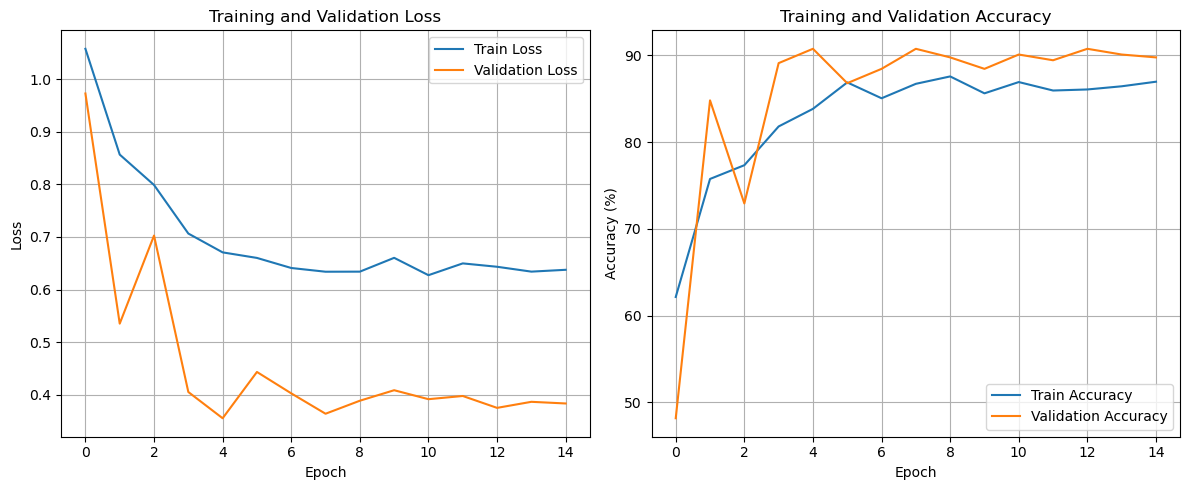

Confusion Matrix:
      0   1  2
0  247  14  6
1    2  13  5
2    4   9  5 where columns are true labels and rows are predicted labels


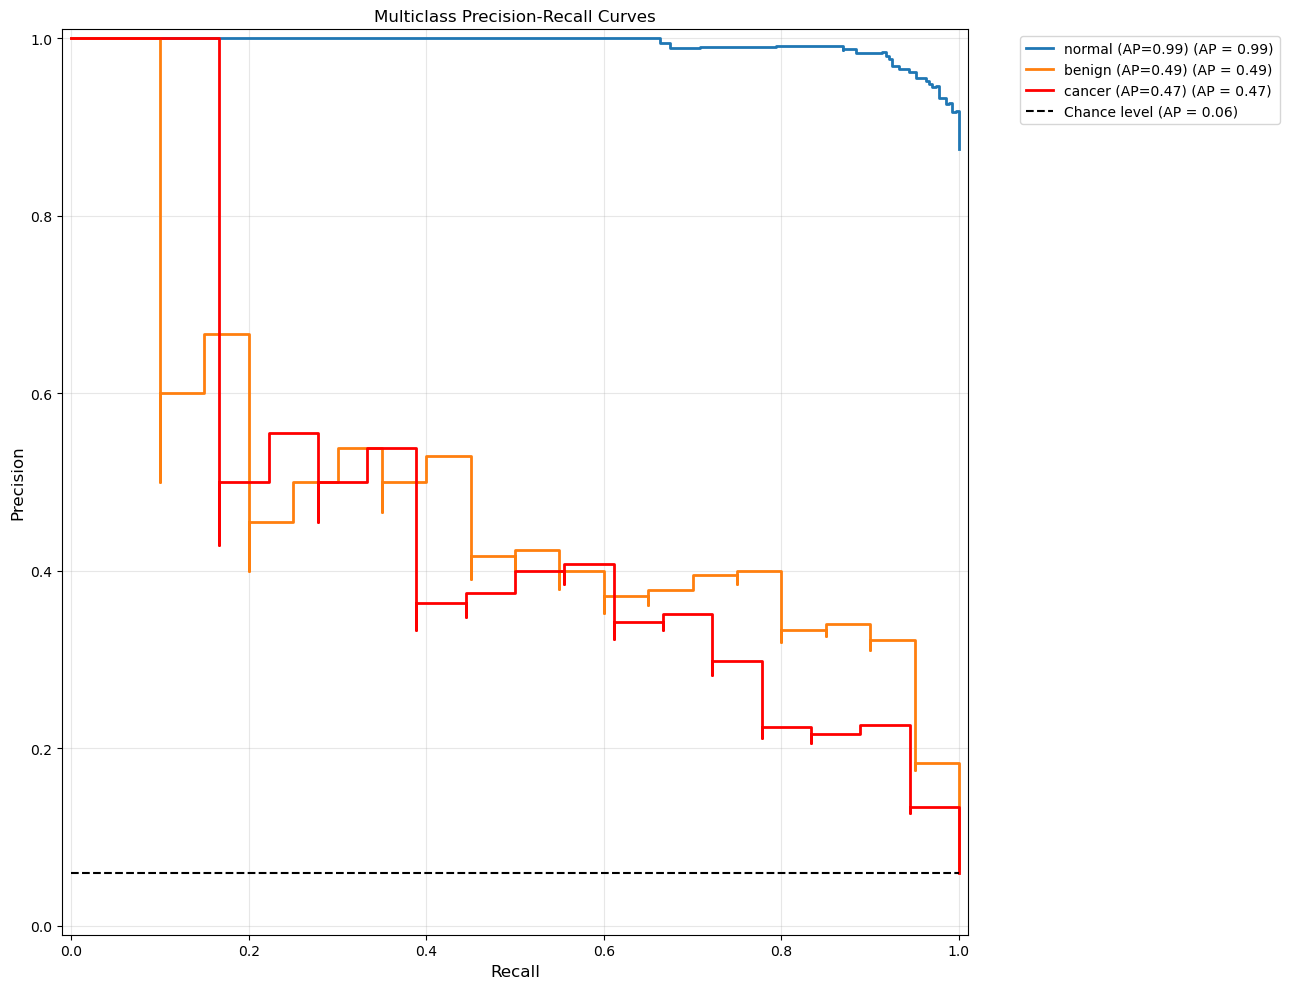

In [22]:
### Back to original dataset
train_dataset = CancerImageDataset(train_data)
val_dataset = CancerImageDataset(val_data)
test_dataset = CancerImageDataset(test_data)
    
# Create DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

#Test the DataLoader
sample_images, sample_labels = next(iter(train_loader))
print(f"img_tensor_shape: {sample_images.shape}")  # 应为 [32, 3, 224, 224]
print(f"label_tensor_shape: {sample_labels.shape}")  # 应为 [32]



def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = ResNet18Transfer(num_classes=3).to(device)
    
    # Define loss function and optimizer
    
    ################## Apply class weighting to loss function
    # Extract all labels from training dataset
    def get_all_labels(dataset):
        return [label for _, label in dataset]

    # Get all labels from training set
    train_labels = get_all_labels(train_dataset)  # Note: using original non-resampled training set
    # If using resampled dataset, the weights would be approximately equal
    ################## Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=np.array(train_labels))
    ################## Apply weights in loss function (using original non-resampled set)
    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
    #criterion = nn.CrossEntropyLoss()  # Unweighted alternative
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    ################## Use StepLR for dynamic learning rate adjustment
    scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
    
    # Training history records
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Training parameters
    ## Debug settings
    epochs_num = 15
    best_acc = 0.0

    # Training loop
    for epoch in range(1, epochs_num+1):
        start_time = time.time()
        
        train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
        val_loss, val_acc = evaluate(model, device, val_loader, criterion)
        scheduler.step()
        
        # Record training metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch}/{epochs_num} | Time: {epoch_time:.2f}s')
        print(f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}%')
        print(f'Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%')
        print('-' * 60)
    
    # Final evaluation
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc = evaluate(model, device, test_loader, criterion)
    print(f'\nFinal Test Performance:')
    print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%')
    
    # Plot training curves
    plot_training_curves(history)
    
    # Generate and analyze prediction results
    test_results = get_predictions(model, device, test_loader)
    y_true = test_results['true_labels']  # Ground truth labels
    y_pred = test_results['predictions']  # Predicted labels
    classes = ['normal','benign','cancer']  # Class names
    cm = confusion_matrix(y_true, y_pred)  # Confusion matrix
    df_cm = pd.DataFrame(cm) 
    
    print("Confusion Matrix:\n", df_cm, "where columns are true labels and rows are predicted labels")
    
    # Plot PR curves for each class
    # Special focus on 'cancer' class
    y_scores = test_results['probabilities']
    plot_multiclass_pr_curves(y_true, y_scores, classes, focus_class='cancer')

if __name__ == '__main__':
    main()

Finally, it was found that the recognition results for minority classes were even slightly better than those of models that had undergone oversampling or weighted loss functions, indicating that the generalization ability of ResNet18 is still very strong. The reason for this situation might be that the data depth of cancer and benign is insufficient, and the features contained in the training set are inadequate to support the generalization ability of the model. For some medical image tasks, a simple classical model combined with sufficient pre-training may be more effective than a complex category balancing strategy. It can be seen from this that ResNet's strong feature extraction ability has certain advantages in transfer learning. Using the pre-trained ResNet18, its ability to extract general features on large-scale datasets may be stronger than that of CNNS trained from scratch. Moreover, residual connections help the network learn multi-scale features better, which is particularly important for small sample categories. Therefore, even without re-sampling or weighting the loss function, better results can still be achieved.